# Analysis of Cell Technology
3 competing cell technologies may claim marketshare in future; Bifacial PERC, bifacial SHJ, and Bifacial TOPCon. Each design has different efficiency and a different silver intensity. This analysis seeks compare these technologies on a mass and energy basis. A psuedo global deployment projection hitting 100% RE targets in 2050 is used so that silver demand can be evaluated at the global level.

Make 4+ scenarios
1. All PERC
2. All SHJ
3. All TOPCon
4. Realistic blend / ITRPV numbers from Martin Springer or Jarett Zuboy – DURAMat tech scounting report
5. All of the above and turn Bifacial ON/OFF

We will use the silver intensity and module efficiency projections from:

    Zhang, Yuchao, Moonyong Kim, Li Wang, Pierre Verlinden, and Brett Hallam. 2021. “Design Considerations for Multi-Terawatt Scale Manufacturing of Existing and Future Photovoltaic Technologies: Challenges and Opportunities Related to Silver, Indium and Bismuth Consumption.” Energy & Environmental Science. https://doi.org/10.1039/D1EE01814K. 

and

    Gervais, Estelle, Shivenes Shammugam, Lorenz Friedrich, and Thomas Schlegl. 2021. “Raw Material Needs for the Large-Scale Deployment of Photovoltaics – Effects of Innovation-Driven Roadmaps on Material Constraints until 2050.” Renewable and Sustainable Energy Reviews 137 (March): 110589. https://doi.org/10.1016/j.rser.2020.110589.

In [1]:
import numpy as np
import pandas as pd
import os,sys
from pathlib import Path
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18})
#plt.rcParams['figure.figsize'] = (10, 6)

cwd = os.getcwd() #grabs current working directory

testfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP' / 'CellTechCompare')
inputfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'TEMP')
baselinesfolder = str(Path().resolve().parent.parent /'PV_ICE' / 'baselines')
supportMatfolder = str(Path().resolve().parent.parent / 'PV_ICE' / 'baselines' / 'SupportingMaterial')

if not os.path.exists(testfolder):
    os.makedirs(testfolder)

# Data Preparation
Bring in the data from Zhang et al 2021 and Gervais et al 2021.

In [2]:
lit_celltech = pd.read_excel(os.path.join(supportMatfolder,'CellTechCompare','PERCvSHJvTOPCon-LitData.xlsx'), sheet_name='Sheet2',
                             header=[0,1,2], index_col=0)

In [3]:
lit_celltech.columns.get_level_values

<bound method MultiIndex.get_level_values of MultiIndex([('Zhang et al 2021 (hallam)',   'PERC',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',   'PERC', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)',    'SHJ',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)',    'SHJ', 'Ag_mgpcell'),
            ('Zhang et al 2021 (hallam)', 'TOPCon',  'ModuleEff'),
            ('Zhang et al 2021 (hallam)', 'TOPCon', 'Ag_mgpcell')],
           names=[None, None, 'year'])>

In [4]:
#Zhang et al Table 2 gives cell size assumptions 166mm cells
cell_size_m2 = np.square(0.166)

In [5]:
#calculate silver use per meter squared for each tech
zhang_perc_Ag_gpm2 = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['Ag_mgpcell']/1000/cell_size_m2 #creates series
zhang_shj_Ag_gpm2 = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['Ag_mgpcell']/1000/cell_size_m2
zhang_topcon_Ag_gpm2 = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['Ag_mgpcell']/1000/cell_size_m2

Gervais et al 2021 also project silver use, but through 2050. We wil use Zhang et al silver intensity through 2030, then a futher decrease from Gervais et al to 2050. There is no projection of TOPCon from Gervais et al, so we will assume a similar magnitude of continued decrease.

In [6]:
lit_celltech.loc[2030]

                                   year      
Zhang et al 2021 (hallam)  PERC    ModuleEff     24.5
                                   Ag_mgpcell    57.0
                           SHJ     ModuleEff     25.3
                                   Ag_mgpcell    99.0
                           TOPCon  ModuleEff     25.0
                                   Ag_mgpcell    95.0
Name: 2030, dtype: float64

In [7]:
Gervais_perc_2050 = pd.Series({2050:40}) #mg/cell
Gervais_shj_2050 = pd.Series({2050:80}) #mg/cell
guess_topcon_2050 = pd.Series({2050:(95-18)}) # mg/cell 99-80 = 19, 57-40 = 17, guess further 18mg decrease
#assuming the same cell size as Zhang et al (it isn't specified in Gervais)
Gervais_perc_2050_gpm2 = Gervais_perc_2050/1000/cell_size_m2
Gervais_shj_2050_gpm2 = Gervais_shj_2050/1000/cell_size_m2
guess_topcon_2050_gpm2 = guess_topcon_2050/1000/cell_size_m2

In [8]:
perc_Ag_gpm2 = pd.concat([zhang_perc_Ag_gpm2.loc[:2049], Gervais_perc_2050_gpm2])
shj_Ag_gpm2 = pd.concat([zhang_shj_Ag_gpm2.loc[:2049], Gervais_shj_2050_gpm2])
topcon_Ag_gpm2 = pd.concat([zhang_topcon_Ag_gpm2.loc[:2049], guess_topcon_2050_gpm2])

In [9]:
#filled projections 2020 through 2050
perc_Ag_gpm2.interpolate(inplace=True)
shj_Ag_gpm2.interpolate(inplace=True)
topcon_Ag_gpm2.interpolate(inplace=True)

Now lets use Zhang et al's projections of efficiency increases. These are reasonably ambitious, achieving ~25% by 2030, but PV is usually an overachiever. We will hold efficiency constant after 2030.

In [10]:
zhang_perc_modeff = lit_celltech['Zhang et al 2021 (hallam)']['PERC']['ModuleEff']
zhang_shj_modeff = lit_celltech['Zhang et al 2021 (hallam)']['SHJ']['ModuleEff']
zhang_topcon_modeff = lit_celltech['Zhang et al 2021 (hallam)']['TOPCon']['ModuleEff']

In [11]:
zhang_perc_modeff.interpolate(inplace=True)
zhang_shj_modeff.interpolate(inplace=True)
zhang_topcon_modeff.interpolate(inplace=True)

In [12]:
modeffs = pd.concat([zhang_perc_modeff,zhang_shj_modeff,zhang_topcon_modeff], axis=1)
modeffs.columns=['PERC','SHJ','TOPCon']
Aguse = pd.concat([perc_Ag_gpm2,shj_Ag_gpm2,topcon_Ag_gpm2], axis=1)
Aguse.columns=['PERC','SHJ','TOPCon']

Text(0, 0.5, 'Module Efficiency [%]')

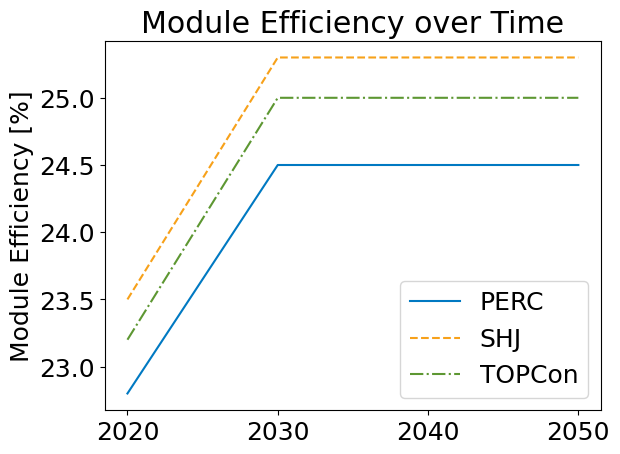

In [13]:
plt.plot(modeffs.index, modeffs['PERC'], color='#0079C2')
plt.plot(modeffs.index, modeffs['SHJ'], color='#F7A11A', ls='--')
plt.plot(modeffs.index, modeffs['TOPCon'], color='#5D9732', ls='-.')

plt.legend(modeffs.columns)
plt.title('Module Efficiency over Time')
plt.ylabel('Module Efficiency [%]')
#plt.rc('font', size=20) #controls default text size
#plt.rc('axes', titlesize=10) #fontsize of the title
#plt.rc('axes', labelsize=10) #fontsize of the x and y labels
#plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
#plt.rc('legend', fontsize=10) #fontsize of the legend
#plt.show()

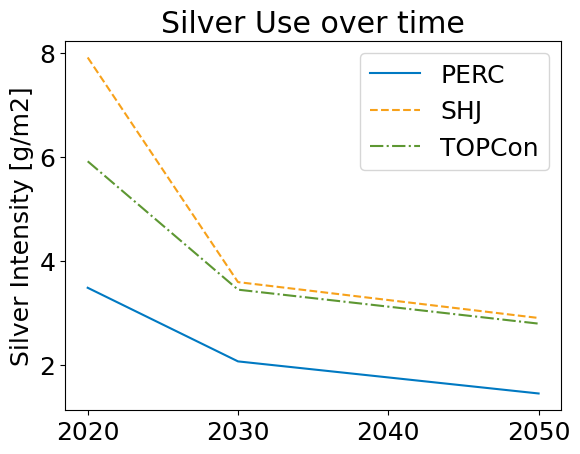

In [14]:
plt.plot(Aguse.index, Aguse['PERC'], color='#0079C2')
plt.plot(Aguse.index, Aguse['SHJ'], color='#F7A11A', ls='--')
plt.plot(Aguse.index, Aguse['TOPCon'], color='#5D9732', ls='-.')
plt.legend(Aguse.columns)
plt.title('Silver Use over time')
plt.ylabel('Silver Intensity [g/m2]')
#plt.rc('font', size=20) #controls default text size
#plt.rc('axes', titlesize=10) #fontsize of the title
#plt.rc('axes', labelsize=10) #fontsize of the x and y labels
#plt.rc('xtick', labelsize=10) #fontsize of the x tick labels
#plt.rc('ytick', labelsize=10) #fontsize of the y tick labels
#plt.rc('legend', fontsize=10) #fontsize of the legend
plt.show()

In [15]:
Aguse.to_csv(os.path.join(testfolder,'ag_gpm2_bytech.csv'))

One important aspect of these technologies is bifaciality. Each has a different bifaciality factor, and they are not expected to increase substantially with time (ITRPV 2022). We plan to explore monofacial and bifacial modules of these technologies (for example residential vs utility). We will use a static inventory of bifacial factors.

In [16]:
bifiFactors = {'PERC':0.7,
              'SHJ':0.9,
              'TOPCon':0.8} # ITRPV 2022, Fig. 58

In [17]:
#PV ICE currently set up to read in a csv of bifi factors, so generate files to read in 
idx_temp = Aguse.index
df_temp = pd.DataFrame(index=idx_temp, columns=['bifi'], dtype=float)
bifi_perc = df_temp.copy()
bifi_perc['bifi'] = bifiFactors['PERC']
bifi_shj = df_temp.copy()
bifi_shj['bifi'] = bifiFactors['SHJ']
bifi_topcon = df_temp.copy()
bifi_topcon['bifi'] = bifiFactors['TOPCon']

In [18]:
bifi_perc.to_csv(path_or_buf=os.path.join(testfolder,'bifi_perc.csv'), index_label='Year')
bifi_shj.to_csv(path_or_buf=os.path.join(testfolder,'bifi_shj.csv'), index_label='Year')
bifi_topcon.to_csv(path_or_buf=os.path.join(testfolder,'bifi_topcon.csv'), index_label='Year')

In [19]:
bifi_perc_path = os.path.join(testfolder,'bifi_perc.csv')
bifi_shj_path = os.path.join(testfolder,'bifi_shj.csv')
bifi_topcon_path = os.path.join(testfolder,'bifi_topcon.csv')

To create a blended scenario, we will use the ITRPV 2022 cell market share projection through 2030, and then keep it constant through 2050.

In [20]:
#insert data from Jarett here
itrpv_celltech_marketshare = pd.read_csv(os.path.join(supportMatfolder,'CellTechCompare','ITRPV_celltech_marketshare.csv'), index_col=0)

In [21]:
itrpv_celltech_marketshare.columns
itrpv_celltech_marketshare.index
#there are more cell techs here than I need - I'm not currently concerned with n-type vs p-type
#the marketshares of "n-type back contact", "n-type other", "tandem si-based" are small and outside scope of study
#remove and renormalize.

Int64Index([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
            2027, 2028, 2029, 2030, 2031, 2032],
           dtype='int64', name='year')

In [22]:
#subset for desired techs
celltech_marketshare_sub_raw = itrpv_celltech_marketshare.loc[2020:].filter(regex=('PERC|TOPCon|SHJ')) 
#interpolate to fill gaps
celltech_marketshare_sub_raw.interpolate(inplace=True, limit_direction='both')
#renormalize
celltech_marketshare_sub_raw['temp_sum'] = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]].sum(axis=1)
celltech_marketshare_sub_raw['scale'] = 1/celltech_marketshare_sub_raw['temp_sum'] #create scaling factor
celltech_marketshare_scaled = celltech_marketshare_sub_raw.iloc[:,[0,1,2,3]]*celltech_marketshare_sub_raw.loc[:,['scale']].values
#celltech_marketshare_scaled.sum(axis=1) # test check that everything adds to 1

In [23]:
celltech_marketshare_scaled.index

Int64Index([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
            2031, 2032],
           dtype='int64', name='year')

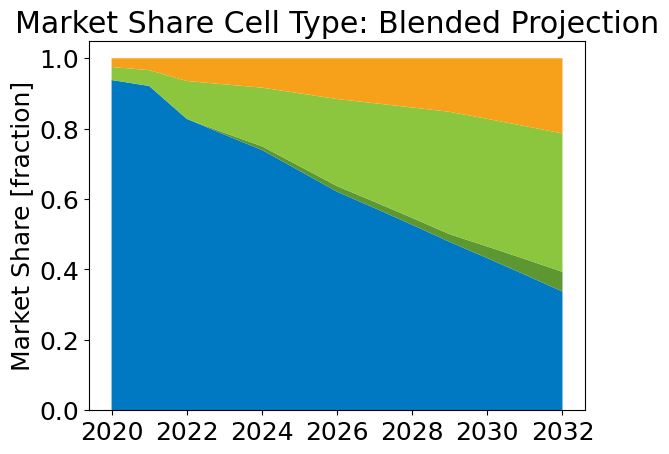

In [24]:
plt.plot([],[],color='#0079C2', label='PERC')
plt.plot([],[],color='#5D9732', label='TOPCon (p-type)')
plt.plot([],[],color='#8CC63F', label='TOPCon (n-type)')
plt.plot([],[],color='#F7A11A', label='SHJ')
#plt.plot([],[],color='red', label='Cell')

plt.stackplot(celltech_marketshare_scaled.index,
              celltech_marketshare_scaled['p-type (PERC)'],
              celltech_marketshare_scaled['p-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (TOPCon)'],
              celltech_marketshare_scaled['n-type (SHJ)'],
              colors = ['#0079C2','#5D9732','#8CC63F','#F7A11A'])

plt.title('Market Share Cell Type: Blended Projection')
plt.ylabel('Market Share [fraction]')
#plt.xlim(1995,2022)
#plt.legend(loc='lower center')
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.show()

In [25]:
celltech_marketshare_scaled['TOPCon'] = celltech_marketshare_scaled.filter(like='TOPCon').sum(axis=1)

Other Assumptions:
- silicon wafer thickness is identical, and improvements are identical
- glass-glass module package for bifacial using 2.5mm glass for both
- module manufacturing energy is identical (until we get better data)
- degradation rates between the technologies are identical (until we get better data)
- Weibull Failure probabilities are identical between technologies (until we get better data)
- No ciruclarity

In [26]:
#glass-glass package mass per area calculation
#ITRPV 2022 Figs 36 and 38, we are assuming that the front and back glass heave equal thickness of 2.5mm
density_glass = 2500*1000 # g/m^3 
glassperm2 = (2.5/1000)* 2 * density_glass
print('The mass per module area of glass is '+str(glassperm2)+' g/m^2')

The mass per module area of glass is 12500.0 g/m^2


Pull in deployment projection. This deployment is based on the Solar Futures report, but has been modified to be more reasonable annual deployment schedule (i.e. manufacturing ramps up). However, this does not achieve 95% RE by 2035, but it does achieve 100% RE in 2050.

In [27]:
sf_reeds_alts = pd.read_excel(os.path.join(supportMatfolder,'SF_reeds_alternates.xlsx'),index_col=0)

In [28]:
sf_reeds = sf_reeds_alts.loc[2023:2050,['MW']]

In [29]:
#try sorting the Reeds Deployment to be in ascending order
sf_reeds['MW'].values.sort() #this sorts the column values in place

In [30]:
sf_reeds['TW_cum'] = sf_reeds['MW'].cumsum()/1e6

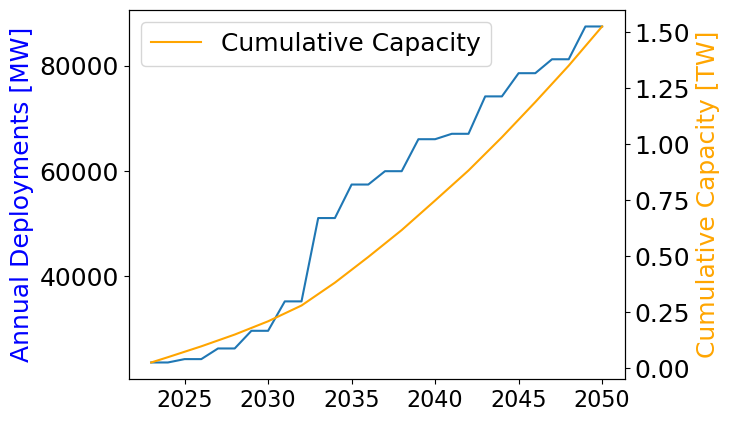

In [31]:
fig, ax1 = plt.subplots()

ax1.plot(sf_reeds['MW'])
ax1.set_ylabel('Annual Deployments [MW]', color='blue')

ax2 = ax1.twinx()
ax2.plot(sf_reeds['TW_cum'], color='orange')
ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')

#ax1.rc('xtick', labelsize=10) #fontsize of the x tick labels
#ax1.rc('ytick', labelsize=18) #fontsize of the y tick labels

plt.legend(['Cumulative Capacity'])
plt.show()

In [32]:
sf_reeds.loc[2030]

MW        29613.993350
TW_cum        0.207411
Name: 2030.0, dtype: float64

In [33]:
sf_reeds.loc[2050]

MW        87426.894740
TW_cum        1.523311
Name: 2050.0, dtype: float64

In [34]:
#historical 2020-2022 from Wood Mac
history = sf_reeds_alts.loc[2020:2022,['Historically annual']]
history.columns=['MW']
projection = sf_reeds[['MW']]
newdeploymentcurve = pd.concat([history,projection],axis=0)

In [35]:
#modify projection to be closer to global scale by x10
newdeploymentcurve_global = newdeploymentcurve*10

In [36]:
newdeploymentcurve_global['TW_cum'] = newdeploymentcurve_global['MW'].cumsum()/1e6
newdeploymentcurve_global.to_csv(os.path.join(testfolder,'deploymentCurve_global.csv'))

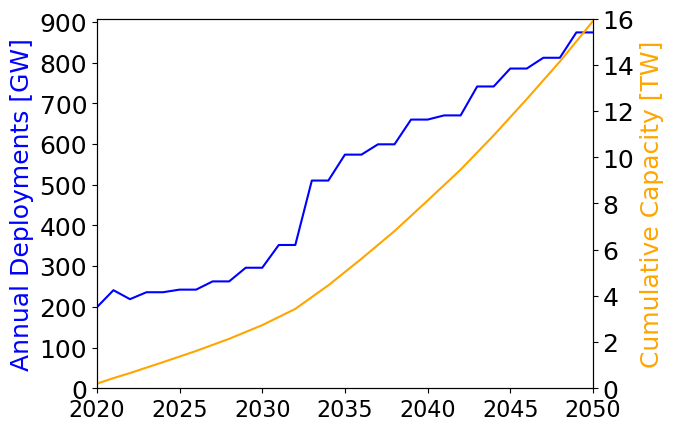

In [37]:
fig, ax1 = plt.subplots()

ax1.plot(newdeploymentcurve_global['MW']/1000, color='blue')
ax1.set_ylabel('Annual Deployments [GW]', color='blue')
#ax1.set_ylim(0, 90)
ax1.set_yticks(range(0,901,100))
ax1.set_xlim(2020,2050)


ax2 = ax1.twinx()
ax2.plot(newdeploymentcurve_global['TW_cum'], color='orange')
ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')
ax2.set_ylim(0, 16)

#plt.legend(['Cumulative Capacity'])
plt.rc('font', size=16) #controls default text size
plt.show()

# Scenario Creation

In [38]:
#creating scenarios for identical power and identical area deployed
scennames = ['PERC_p','SHJ_p','TOPCon_p', 'PERC_a','SHJ_a','TOPCon_a'] #add later Blend and bifi on/off
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [39]:
#load in a baseline and materials for modification
import PV_ICE

sim1 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames:
    sim1.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim1.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [40]:
#trim to 2020-2050, this trims module and materials
sim1.trim_Years(startYear=2020)

endYear not provided. Setting to end year of Module data 2050


In [41]:
#no circularity
sim1.scenMod_noCircularity()

In [42]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(newdeploymentcurve.index-1),'new_Installed_Capacity_[MW]'] = newdeploymentcurve_global['MW'].values

In [43]:
#module eff
#modeffs
for scen in scennames:
    sim1.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

In [44]:
#glass modify
for scen in scennames:
    sim1.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2

In [45]:
#silver modify
#Aguse
for scen in scennames:
    sim1.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values

Check to make sure the modifications took.

In [46]:
sim1.scenario['SHJ_a'].dataIn_m.head(10)

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,199145.501006,23.50,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,240948.044652,23.68,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,218931.470533,23.86,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,235967.289600,24.04,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,235967.289600,24.22,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
5,2025,242364.159700,24.40,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,2026,242364.159700,24.58,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
7,2027,262583.013200,24.76,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
8,2028,262583.013200,24.94,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
9,2029,296139.933500,25.12,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [47]:
sim1.scenario['SHJ_p'].material['silver'].matdataIn_m.head()

,year,mat_virgin_eff,mat_massperm2,mat_MFG_eff,mat_MFG_scrap_Recycled,mat_MFG_scrap_Recycling_eff,mat_MFG_scrap_Recycled_into_HQ,mat_MFG_scrap_Recycled_into_HQ_Reused4MFG,mat_PG3_ReMFG_target,mat_ReMFG_yield,mat_PG4_Recycling_target,mat_Recycling_yield,mat_EOL_Recycled_into_HQ,mat_EOL_RecycledHQ_Reused4MFG
0,2020,75.0,7.911163,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,75.0,7.479315,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,75.0,7.047467,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,75.0,6.615619,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,75.0,6.183771,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
sim1.scenario['SHJ_p'].material['silicon'].matdataIn_e.head()

,year,e_mat_extraction,e_mat_MFG,e_mat_MFG_fuelfraction,e_mat_MFGScrap_LQ,e_mat_MFGScrap_HQ,e_mat_Landfill,e_mat_Landfill_fuelfraction,e_mat_EoL_ReMFG_clean,e_mat_Recycled_LQ,e_mat_Recycled_HQ,e_mat_Recycled_HQ_fuelfraction
0,2020,0.0062,169.06,0.22,24.5,600.0,0.09,0.0,0.4,1.6,138.38,0.20
1,2021,0.0062,170.73,0.21,24.5,600.0,0.09,0.0,0.4,1.6,143.04,0.19
2,2022,0.0062,169.05,0.20,24.5,600.0,0.09,0.0,0.4,1.6,144.33,0.19
3,2023,0.0062,168.80,0.20,24.5,600.0,0.09,0.0,0.4,1.6,144.20,0.19
4,2024,0.0062,169.09,0.20,24.5,600.0,0.09,0.0,0.4,1.6,144.60,0.19


# Run Simulations

## Option 1: Compare with Idential Power Installed

In [49]:
scennames_p = ['PERC_p','SHJ_p','TOPCon_p']
bifipaths = [bifi_perc_path,bifi_shj_path,bifi_topcon_path]

In [50]:
#option 1, install identical power
sim1.calculateFlows(scenarios='PERC_p', bifacialityfactors=bifi_perc_path)
sim1.calculateFlows(scenarios='SHJ_p', bifacialityfactors=bifi_shj_path)
sim1.calculateFlows(scenarios='TOPCon_p', bifacialityfactors=bifi_topcon_path)

perc_p_yearly, perc_p_cum = sim1.aggregateResults(scenarios='PERC_p')
shj_p_yearly, shj_p_cum = sim1.aggregateResults(scenarios='SHJ_p')
topcon_p_yearly, topcon_p_cum = sim1.aggregateResults(scenarios='TOPCon_p')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_p
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_p
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ_p
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ_p
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  TOPCon_p
*******************

## Option 2: Compare with Idential Area Installed

In [51]:
scennames_a = ['PERC_a','SHJ_a','TOPCon_a']
bifipaths = [bifi_perc_path,bifi_shj_path,bifi_topcon_path]

In [52]:
#Calculate Area deployed based on PERC and modified SF projection above
idx_temp = Aguse.index #grab matching index
area_deploy = pd.DataFrame(index=idx_temp, dtype=float) #create an empty DF
area_deploy['Area'] = sim1.scenario['PERC_p'].dataOut_m['Area'].values
area_deploy.head()

,Area
2020,8.163039e+08
2021,9.803443e+08
2022,8.842215e+08
2023,9.460754e+08
2024,9.392256e+08


In [53]:
#option 1, install identical power
sim1.calculateFlows(scenarios='PERC_a', bifacialityfactors=bifi_perc_path, installByArea=list(area_deploy['Area']))
sim1.calculateFlows(scenarios='SHJ_a', bifacialityfactors=bifi_shj_path,  installByArea=list(area_deploy['Area']))
sim1.calculateFlows(scenarios='TOPCon_a', bifacialityfactors=bifi_topcon_path,  installByArea=list(area_deploy['Area']))

perc_a_yearly, perc_a_cum = sim1.aggregateResults(scenarios='PERC_a')
shj_a_yearly, shj_a_cum = sim1.aggregateResults(scenarios='SHJ_a')
topcon_a_yearly, topcon_a_cum = sim1.aggregateResults(scenarios='TOPCon_a')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_a
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_a
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ_a
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ_a
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy fo

In [54]:
all_results_yearly, all_results_cum = sim1.aggregateResults()
all_results_yearly.columns

Index(['VirginStock_glass_sim1_PERC_p_[Tonnes]',
       'VirginStock_silver_sim1_PERC_p_[Tonnes]',
       'VirginStock_silicon_sim1_PERC_p_[Tonnes]',
       'VirginStock_Module_sim1_PERC_p_[Tonnes]',
       'WasteAll_glass_sim1_PERC_p_[Tonnes]',
       'WasteAll_silver_sim1_PERC_p_[Tonnes]',
       'WasteAll_silicon_sim1_PERC_p_[Tonnes]',
       'WasteAll_Module_sim1_PERC_p_[Tonnes]',
       'WasteEOL_glass_sim1_PERC_p_[Tonnes]',
       'WasteEOL_silver_sim1_PERC_p_[Tonnes]',
       ...
       'ActiveCapacity_sim1_SHJ_p_[MW]',
       'DecommisionedCapacity_sim1_SHJ_p_[MW]',
       'ActiveCapacity_sim1_TOPCon_p_[MW]',
       'DecommisionedCapacity_sim1_TOPCon_p_[MW]',
       'ActiveCapacity_sim1_PERC_a_[MW]',
       'DecommisionedCapacity_sim1_PERC_a_[MW]',
       'ActiveCapacity_sim1_SHJ_a_[MW]',
       'DecommisionedCapacity_sim1_SHJ_a_[MW]',
       'ActiveCapacity_sim1_TOPCon_a_[MW]',
       'DecommisionedCapacity_sim1_TOPCon_a_[MW]'],
      dtype='object', length=114)

### Compare Effective Capacity

In [55]:
activecapacity_yearly_TW = pd.DataFrame(all_results_yearly.filter(like='ActiveCapacity'))/1e6
activecapacity_yearly_TW_p = activecapacity_yearly_TW.filter(like='_p')
activecapacity_yearly_TW_a = activecapacity_yearly_TW.filter(like='_a')


Text(0, 0.5, 'Effective Capacity [TW]')

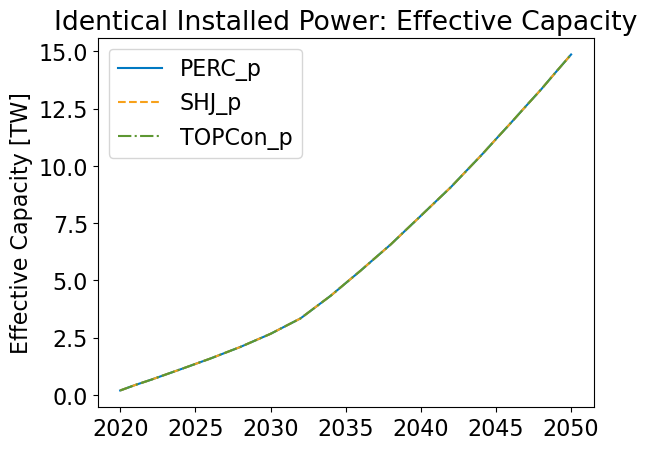

In [56]:
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[0]], color='#0079C2')
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[1]], color='#F7A11A', ls='--')
plt.plot(activecapacity_yearly_TW_p.index, activecapacity_yearly_TW_p.iloc[:,[2]], color='#5D9732', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Installed Power: Effective Capacity')
plt.ylabel('Effective Capacity [TW]')

Text(0, 0.5, 'Effective Capacity [TW]')

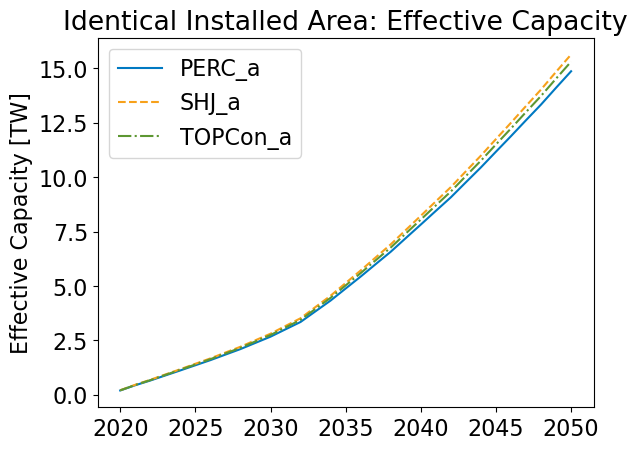

In [57]:
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[0]], color='#0079C2')
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[1]], color='#F7A11A', ls='--')
plt.plot(activecapacity_yearly_TW_a.index, activecapacity_yearly_TW_a.iloc[:,[2]], color='#5D9732', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Installed Area: Effective Capacity')
plt.ylabel('Effective Capacity [TW]')

### Compare Area Deployed

In [58]:
#compile all energy out results
area_deployed=pd.DataFrame()
for scen in scennames:
    # add the scen name as a prefix for later filtering
    scen_area = sim1.scenario[scen].dataOut_m[['Cumulative_Active_Area']].add_prefix(str(scen+'_'))
    #concat into one large df
    area_deployed = pd.concat([area_deployed, scen_area], axis=1)

area_deployed.index = idx_temp
area_deployed.tail()

,PERC_p_Cumulative_Active_Area,SHJ_p_Cumulative_Active_Area,TOPCon_p_Cumulative_Active_Area,PERC_a_Cumulative_Active_Area,SHJ_a_Cumulative_Active_Area,TOPCon_a_Cumulative_Active_Area
2046,4.786576e+10,4.551035e+10,4.648721e+10,4.786576e+10,4.786576e+10,4.786576e+10
2047,5.086479e+10,4.836112e+10,4.939884e+10,5.086479e+10,5.086479e+10,5.086479e+10
2048,5.383243e+10,5.118201e+10,5.227991e+10,5.383243e+10,5.383243e+10,5.383243e+10
2049,5.699941e+10,5.419233e+10,5.535445e+10,5.699941e+10,5.699941e+10,5.699941e+10
2050,6.012108e+10,5.715954e+10,5.838492e+10,6.012108e+10,6.012108e+10,6.012108e+10


Text(0, 0.5, 'Area [million m2]')

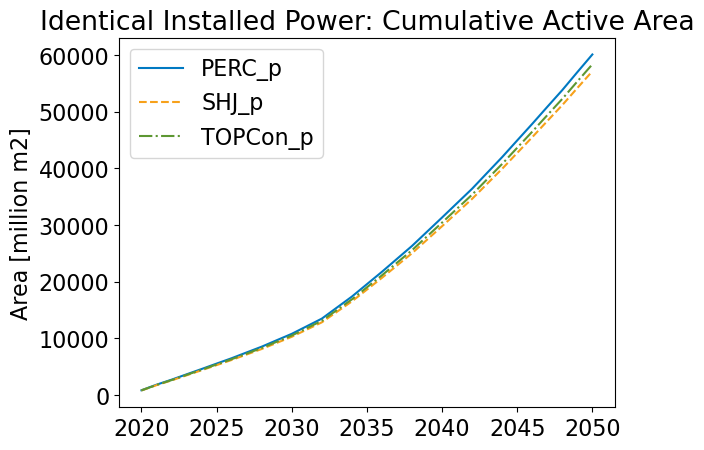

In [59]:
plt.plot(area_deployed.index, area_deployed.iloc[:,[0]]/1e6, color='#0079C2')
plt.plot(area_deployed.index, area_deployed.iloc[:,[1]]/1e6, color='#F7A11A', ls='--')
plt.plot(area_deployed.index, area_deployed.iloc[:,[2]]/1e6, color='#5D9732', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Installed Power: Cumulative Active Area')
plt.ylabel('Area [million m2]')

Text(0, 0.5, 'Area [million m$^2$]')

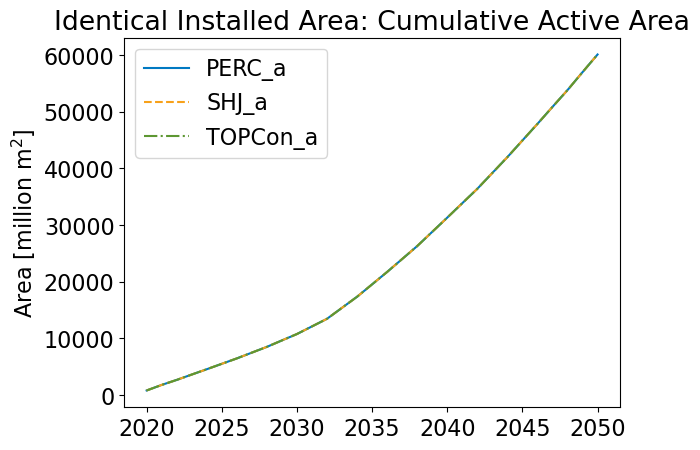

In [60]:
plt.plot(area_deployed.index, area_deployed.iloc[:,[3]]/1e6, color='#0079C2')
plt.plot(area_deployed.index, area_deployed.iloc[:,[4]]/1e6, color='#F7A11A', ls='--')
plt.plot(area_deployed.index, area_deployed.iloc[:,[5]]/1e6, color='#5D9732', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Installed Area: Cumulative Active Area')
plt.ylabel('Area [million m$^2$]')

## Compare Silver Demand

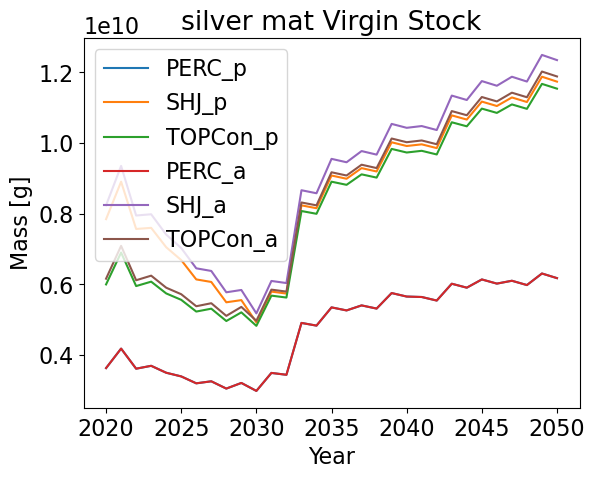

In [61]:
sim1.plotMaterialComparisonAcrossScenarios(keyword='mat_Virgin_Stock', material='silver')

In [62]:
annual_demand_silver = all_results_yearly.filter(like='VirginStock_silver')
annual_demand_silver.columns=scennames
annual_demand_silver.to_csv(os.path.join(testfolder,'annual_demand_silver.csv'))

In [63]:
silver_demand_cum = pd.DataFrame(all_results_cum.filter(like='VirginStock_silver').loc[2050]).T

In [64]:
silver_demand_cum
silver_demand_cum.to_csv(os.path.join(testfolder,'Ag_demand_cum2050_allScens.csv'))

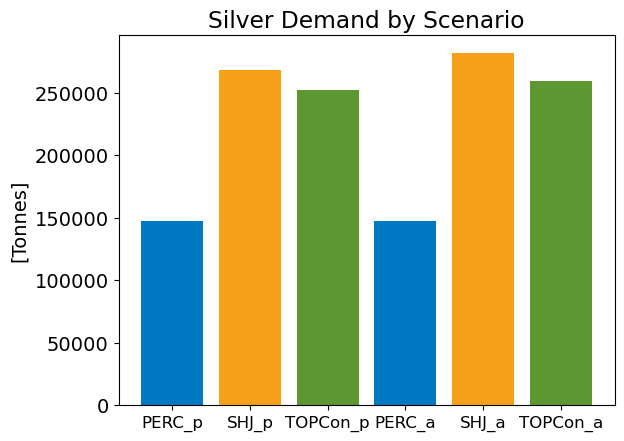

In [201]:
plt.bar(silver_demand_cum.columns, silver_demand_cum.loc[2050], tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Silver Demand by Scenario')
plt.ylabel('[Tonnes]')
plt.rc('xtick', labelsize=12) #fontsize of the x tick labels

In [66]:
silver_demand_cum

,VirginStock_silver_sim1_PERC_p_[Tonnes],VirginStock_silver_sim1_SHJ_p_[Tonnes],VirginStock_silver_sim1_TOPCon_p_[Tonnes],VirginStock_silver_sim1_PERC_a_[Tonnes],VirginStock_silver_sim1_SHJ_a_[Tonnes],VirginStock_silver_sim1_TOPCon_a_[Tonnes]
2050,146886.124908,267804.452857,252181.780974,146886.124908,281638.847956,259640.845021


In [67]:
all_results_yearly.loc[2050].filter(like='newInstalledCapacity') 
#FYI the area deployment doesn't overwrite the new installs column - do not trust those numbers!

newInstalledCapacity_sim1_PERC_p_[MW]      874268.9474
newInstalledCapacity_sim1_SHJ_p_[MW]       874268.9474
newInstalledCapacity_sim1_TOPCon_p_[MW]    874268.9474
newInstalledCapacity_sim1_PERC_a_[MW]      874268.9474
newInstalledCapacity_sim1_SHJ_a_[MW]       874268.9474
newInstalledCapacity_sim1_TOPCon_a_[MW]    874268.9474
Name: 2050, dtype: float64

In [68]:
activecapacity = pd.DataFrame(all_results_yearly.loc[2050].filter(like='ActiveCapacity')).T/1e6
#activecapacity
newInstalledCap_TW = pd.DataFrame(all_results_yearly.loc[2050].filter(like='newInstalledCapacity')).T/1e6
newInstalledCap_TW

,newInstalledCapacity_sim1_PERC_p_[MW],newInstalledCapacity_sim1_SHJ_p_[MW],newInstalledCapacity_sim1_TOPCon_p_[MW],newInstalledCapacity_sim1_PERC_a_[MW],newInstalledCapacity_sim1_SHJ_a_[MW],newInstalledCapacity_sim1_TOPCon_a_[MW]
2050,0.874269,0.874269,0.874269,0.874269,0.874269,0.874269


Calculate mg/W over time

In [69]:
newInstalledCap_MW_annual = pd.DataFrame(all_results_yearly.filter(like='newInstalledCapacity'))
newInstalledCap_MW_annual.columns = scennames

In [70]:
annual_demand_silver_kg = annual_demand_silver*1000
ag_annual_mgpW = annual_demand_silver_kg/newInstalledCap_MW_annual #kg/MW = mg/W
ag_annual_mgpW.loc[2050]

PERC_p       7.062816
SHJ_p       13.427981
TOPCon_p    13.200632
PERC_a       7.062816
SHJ_a       14.125632
TOPCon_a    13.595921
Name: 2050, dtype: float64

In [203]:
#silver_demand_cum #tonne
newInstalledCap_MW_annual_cum = newInstalledCap_MW_annual.cumsum()
silver_demand_cum.columns

Index(['PERC_p', 'SHJ_p', 'TOPCon_p', 'PERC_a', 'SHJ_a', 'TOPCon_a'], dtype='object')

In [204]:
agintensity_mgpW = silver_demand_cum*1000/newInstalledCap_MW_annual_cum.loc[2050] #kg/MW = mg/W
agintensity_mgpW

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,9.242691,16.85138,15.868336,9.242691,17.721898,16.337691


Text(0, 0.5, 'mg/W')

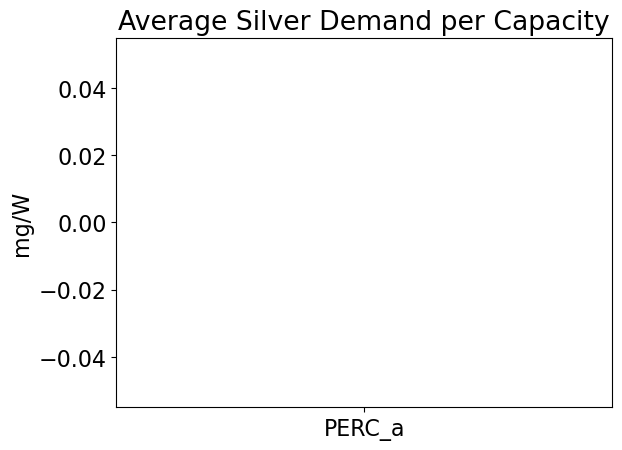

In [73]:
plt.bar(agintensity_mgpW.columns[0:3], agintensity_mgpW.loc[2050][0:3], color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Average Silver Demand per Capacity')
plt.ylabel('mg/W')


## Energy Data Org

In [74]:
#compile all energy out results
energy_mod=pd.DataFrame()
for scen in scennames:
    # add the scen name as a prefix for later filtering
    scende = sim1.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod = pd.concat([energy_mod, scende], axis=1)

energy_mod.tail()

,PERC_p_mod_MFG,PERC_p_mod_Install,PERC_p_mod_OandM,PERC_p_mod_Repair,PERC_p_mod_Demount,PERC_p_mod_Store,PERC_p_mod_Resell_Certify,PERC_p_mod_ReMFG_Disassembly,PERC_p_mod_Recycle_Crush,PERC_p_e_out_annual_[Wh],...,TOPCon_a_mod_MFG,TOPCon_a_mod_Install,TOPCon_a_mod_OandM,TOPCon_a_mod_Repair,TOPCon_a_mod_Demount,TOPCon_a_mod_Store,TOPCon_a_mod_Resell_Certify,TOPCon_a_mod_ReMFG_Disassembly,TOPCon_a_mod_Recycle_Crush,TOPCon_a_e_out_annual_[Wh]
26,1.015141e+13,2.846676e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.893346e+16,...,1.015141e+13,2.846676e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.967769e+16
27,1.049319e+13,2.942517e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.009841e+16,...,1.049319e+13,2.942517e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.088884e+16
28,1.049319e+13,2.942517e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.124680e+16,...,1.049319e+13,2.942517e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.208280e+16
29,1.129815e+13,3.168245e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.247568e+16,...,1.129815e+13,3.168245e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.336047e+16
30,1.129815e+13,3.168245e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.368309e+16,...,1.129815e+13,3.168245e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.461584e+16


In [75]:
energy_mat = pd.DataFrame()
for scen in scennames:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim1.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat = pd.concat([energy_mat, scenmatde], axis=1)

energy_mat.tail()

,PERC_p_glass_mat_extraction,PERC_p_glass_mat_MFG_virgin,PERC_p_glass_mat_MFGScrap_LQ,PERC_p_glass_mat_MFGScrap_HQ,PERC_p_glass_mat_Landfill,PERC_p_glass_mat_EoL_ReMFG_clean,PERC_p_glass_mat_Recycled_LQ,PERC_p_glass_mat_Recycled_HQ,PERC_p_silver_mat_extraction,PERC_p_silver_mat_MFG_virgin,...,TOPCon_a_silver_mat_Recycled_LQ,TOPCon_a_silver_mat_Recycled_HQ,TOPCon_a_silicon_mat_extraction,TOPCon_a_silicon_mat_MFG_virgin,TOPCon_a_silicon_mat_MFGScrap_LQ,TOPCon_a_silicon_mat_MFGScrap_HQ,TOPCon_a_silicon_mat_Landfill,TOPCon_a_silicon_mat_EoL_ReMFG_clean,TOPCon_a_silicon_mat_Recycled_LQ,TOPCon_a_silicon_mat_Recycled_HQ
26,3.989364e+11,1.356148e+14,0.0,0.0,1.859261e+11,0.0,0.0,0.0,1.605243e+08,1.565112e+12,...,0.0,0.0,2.939341e+10,2.408600e+14,0.0,0.0,4.070711e+10,0.0,0.0,0.0
27,4.123676e+11,1.401807e+14,0.0,0.0,2.176776e+11,0.0,0.0,0.0,1.626790e+08,1.586120e+12,...,0.0,0.0,3.038301e+10,2.489692e+14,0.0,0.0,4.285404e+10,0.0,0.0,0.0
28,4.123676e+11,1.401807e+14,0.0,0.0,2.530008e+11,0.0,0.0,0.0,1.594292e+08,1.554435e+12,...,0.0,0.0,3.038301e+10,2.489692e+14,0.0,0.0,4.392868e+10,0.0,0.0,0.0
29,4.440014e+11,1.509343e+14,0.0,0.0,3.042588e+11,0.0,0.0,0.0,1.681604e+08,1.639564e+12,...,0.0,0.0,3.271377e+10,2.680683e+14,0.0,0.0,4.826380e+10,0.0,0.0,0.0
30,4.440014e+11,1.509343e+14,0.0,0.0,3.552260e+11,0.0,0.0,0.0,1.646614e+08,1.605448e+12,...,0.0,0.0,3.271377e+10,2.680683e+14,0.0,0.0,4.980793e+10,0.0,0.0,0.0


In [76]:
allenergy = pd.concat([energy_mod,energy_mat], axis=1)
allenergy.index=idx_temp

## Graphing Energy Generation

In [77]:
energyGen = allenergy.filter(like='e_out_annual')

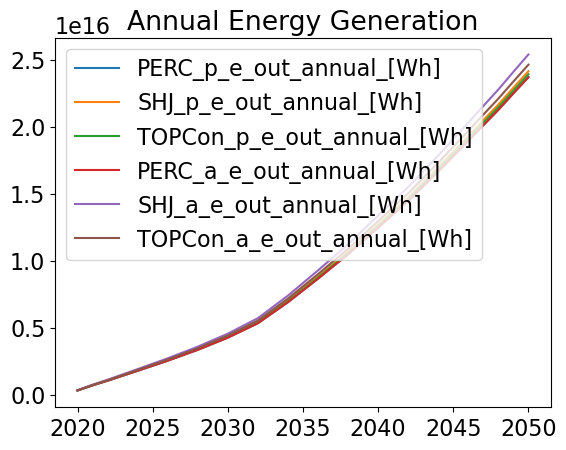

In [78]:
fig, ax1 = plt.subplots()

ax1.plot(energyGen)
#ax1.set_ylabel('Annual Deployments [MW]', color='blue')

#ax2 = ax1.twinx()
#ax2.plot(sf_reeds['TW_cum'], color='orange')
#ax2.set_ylabel('Cumulative Capacity [TW]', color='orange')
#ax1.set_yscale('log')

plt.legend(energyGen.columns)
plt.title('Annual Energy Generation')
plt.show()

In [79]:
energyGen_p = energyGen.filter(like='_p')/1e12
energyGen_a = energyGen.filter(like='_a')/1e12

Text(0, 0.5, 'Energy Generated [TWh]')

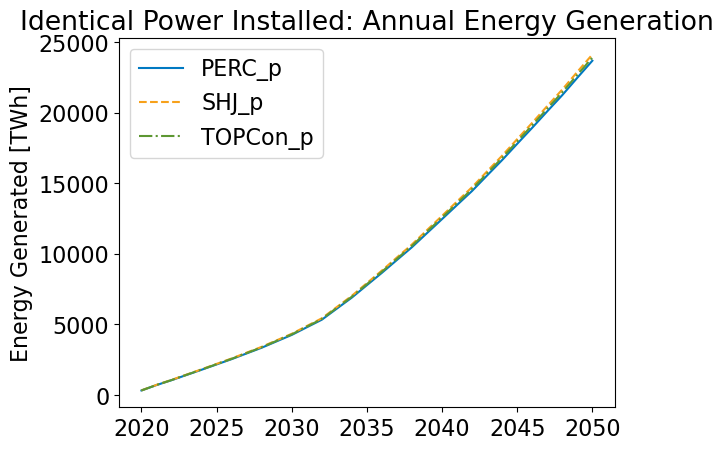

In [80]:
#plt.plot(energyGen_p)#, color=['#006fa2','#ee005b','#734296'])
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[0]], color='#0079C2')
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[1]], color='#F7A11A', ls='--')
plt.plot(energyGen_p.index, energyGen_p.iloc[:,[2]], color='#5D9732', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Power Installed: Annual Energy Generation')
plt.ylabel('Energy Generated [TWh]')

Text(0, 0.5, 'Energy Generated [TWh]')

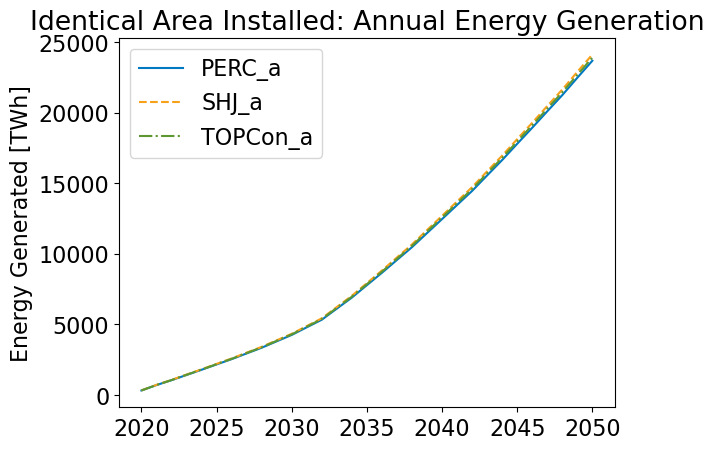

In [81]:
#plt.plot(energyGen_p)#, color=['#006fa2','#ee005b','#734296'])
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[0]], color='#0079C2')
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[1]], color='#F7A11A', ls='--')
plt.plot(energyGen_a.index, energyGen_a.iloc[:,[2]], color='#5D9732', ls='-.')
plt.legend(scennames_a)
plt.title('Identical Area Installed: Annual Energy Generation')
plt.ylabel('Energy Generated [TWh]')

Or as a bar plot

In [82]:
energyGen_cum = energyGen.cumsum()
energyGen_cum_2050 = energyGen_cum.loc[[2050]]
energyGen_cum_2050/1e12
energyGen_cum_2050.columns = scennames
energyGen_cum_2050

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,2.922153e+17,2.976772e+17,2.949462e+17,2.922153e+17,3.130398e+17,3.036296e+17


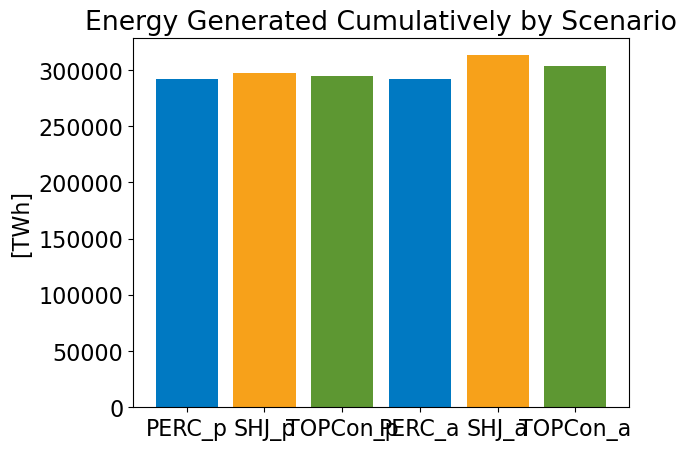

In [83]:
plt.bar(energyGen_cum_2050.columns, energyGen_cum_2050.loc[2050]/1e12, 
        tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Energy Generated Cumulatively by Scenario')
plt.ylabel('[TWh]')
plt.rc('font', size=14) #controls default text size
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels

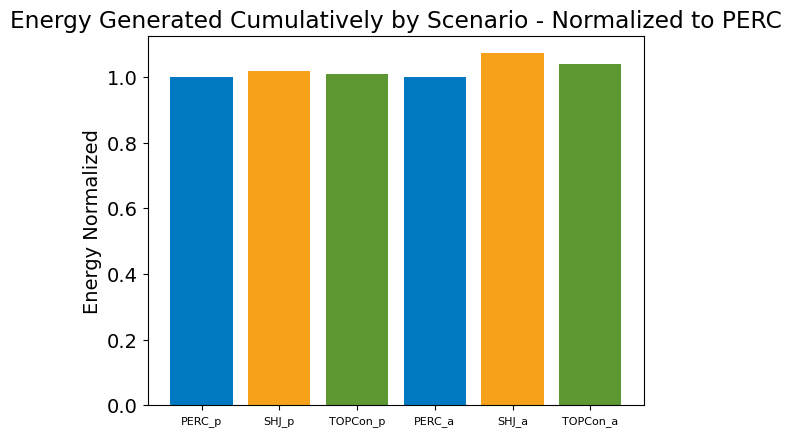

In [84]:
energyGen_cum_2050_norm = energyGen_cum_2050/energyGen_cum_2050.loc[2050,'PERC_a']
plt.bar(energyGen_cum_2050_norm.columns, energyGen_cum_2050_norm.loc[2050], tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Energy Generated Cumulatively by Scenario - Normalized to PERC')
plt.ylabel('Energy Normalized')
plt.rc('font', size=14) #controls default text size
plt.rc('xtick', labelsize=8) #fontsize of the x tick labels

In [85]:
energyGen_cum_2050_norm

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.0,1.018692,1.009346,1.0,1.071265,1.039061


## Energy vs Silver Demand

In [86]:
energyGen_cum_2050.columns=silver_demand_cum.columns=scennames
whpag = (energyGen_cum_2050)/silver_demand_cum #Wh generated cumulative, per silver demand
normalizer = whpag.loc[2050,'PERC_a']
whpag/normalizer

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.0,0.558735,0.587905,1.0,0.558708,0.587826


Text(0, 0.5, '[TWh/tonnes]')

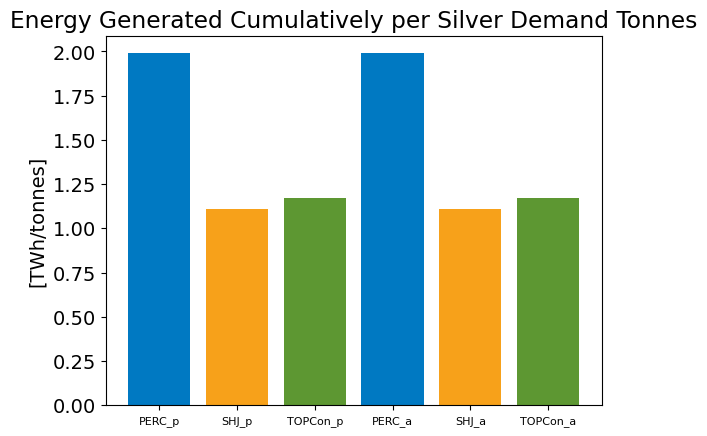

In [87]:
plt.bar(whpag.columns, whpag.loc[2050]/1e12, tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Energy Generated Cumulatively per Silver Demand Tonnes')
plt.ylabel('[TWh/tonnes]')

In [88]:
energyGen_cum_2050.columns=silver_demand_cum.columns=scennames
agpwh= silver_demand_cum/(energyGen_cum_2050) #Wh generated cumulative, per silver demand
normalizer = agpwh.loc[2050,'PERC_a']
agpwh_norm = agpwh/normalizer
agpwh_norm

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.0,1.789758,1.700956,1.0,1.789843,1.701183


Text(0, 0.5, '[tonnes/TWh] Normalized')

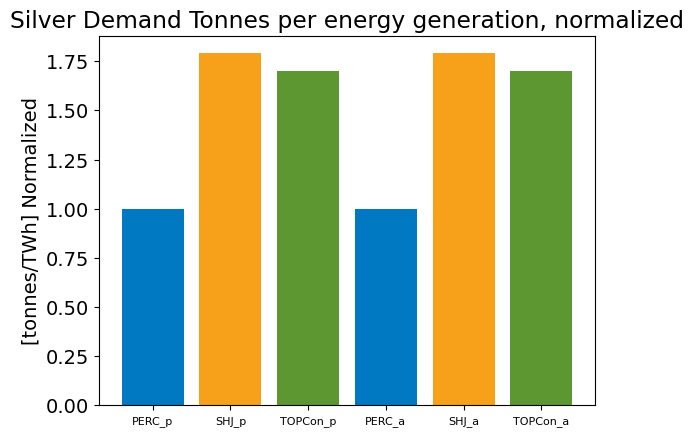

In [89]:
plt.bar(agpwh_norm.columns, agpwh_norm.loc[2050], tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Silver Demand Tonnes per energy generation, normalized')
plt.ylabel('[tonnes/TWh] Normalized')

## Net Energy Calcs

In [90]:
#categorize the energy in values into lifecycle stages
mfg_energies = ['mod_MFG','mat_extraction','mat_MFG_virgin']
mfg_recycle_energies_LQ = ['mat_MFGScrap_LQ'] #LQ and HQ are separate becuase LQ is only LQ
mfg_recycle_energies_HQ = ['mat_MFGScrap_HQ'] #and HQ material is E_LQ + E_HQ
use_energies = ['mod_Install','mod_OandM','mod_Repair']
eol_energies = ['mat_Landfill','mod_Demount','mod_Store','mod_Resell_Certify']
eol_remfg_energies = ['mod_ReMFG_Disassmbly','mat_EoL_ReMFG_clean']
eol_recycle_energies_LQ = ['mod_Recycle_Crush','mat_Recycled_LQ']
eol_recycle_energies_HQ = ['mod_Recycle_Crush','mat_Recycled_HQ']

energy_demands_keys = [mfg_energies,mfg_recycle_energies_LQ,mfg_recycle_energies_HQ,use_energies,eol_energies,
                  eol_remfg_energies,eol_recycle_energies_LQ,eol_recycle_energies_HQ]
import itertools
energy_demands_flat = list(itertools.chain(*energy_demands_keys))
#energy_demands_flat

In [91]:
#select the non energy generation columns for all scenarios
energy_demands = allenergy.loc[:,~allenergy.columns.isin(energyGen.columns)] 
edemand_perc_p = energy_demands.filter(like='PERC_p')
edemand_shj_p = energy_demands.filter(like='SHJ_p')
edemand_topcon_p = energy_demands.filter(like='TOPCon_p')
edemand_perc_a = energy_demands.filter(like='PERC_a')
edemand_shj_a = energy_demands.filter(like='SHJ_a')
edemand_topcon_a = energy_demands.filter(like='TOPCon_a')


In [92]:
#for each scenario, create a cumulative total energy demand
for scen in scennames:
    colname = str(scen+'_e_demand_total')
    energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)

C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_2768\1996546283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_2768\1996546283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_demands[colname] = energy_demands.filter(like=scen).sum(axis=1)
C:\Users\hmirletz\AppData\Local\Temp\1\ipykernel_2768\1996546283.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [93]:
energy_demands_annual = energy_demands.filter(like='e_demand_total')
yrlyedemand_perc_p = energy_demands_annual.filter(like='PERC_p')
yrlyedemand_shj_p = energy_demands_annual.filter(like='SHJ_p')
yrlyedemand_topcon_p = energy_demands_annual.filter(like='TOPCon_p')
yrlyedemand_perc_a = energy_demands_annual.filter(like='PERC_a')
yrlyedemand_shj_a = energy_demands_annual.filter(like='SHJ_a')
yrlyedemand_topcon_a = energy_demands_annual.filter(like='TOPCon_a')

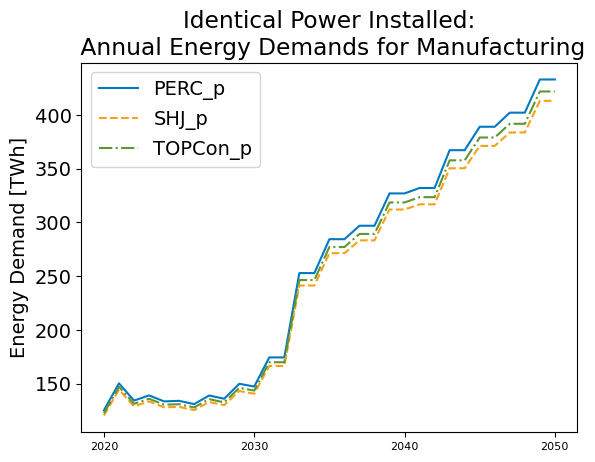

In [94]:
#plt.plot(energy_demands_annual)
plt.plot(yrlyedemand_perc_p.index, yrlyedemand_perc_p/1e12, color='#0079C2')
plt.plot(yrlyedemand_shj_p.index, yrlyedemand_shj_p/1e12, color='#F7A11A', ls='--')
plt.plot(yrlyedemand_topcon_p.index, yrlyedemand_topcon_p/1e12, color='#5D9732', ls='-.')
plt.legend(scennames_p)
plt.title('Identical Power Installed:\n Annual Energy Demands for Manufacturing')
plt.ylabel('Energy Demand [TWh]')
plt.rc('font', size=14) #controls default text size
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.show()

In [95]:
energy_demand_total_cum = energy_demands.filter(like='e_demand_total').cumsum()
energy_demand_total_cum_2050 = energy_demand_total_cum.loc[[2050]]
energy_demand_total_cum_2050.columns = scennames

In [96]:
energy_demand_total_cum_2050/1e12

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,8036.094822,7673.841537,7832.934303,8036.094822,8071.137039,8065.416419


In [97]:
energy_demand_total_cum_2050/energy_demand_total_cum_2050.loc[2050,'PERC_p']

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,1.0,0.954922,0.974719,1.0,1.004361,1.003649


Text(0, 0.5, '[TWh]')

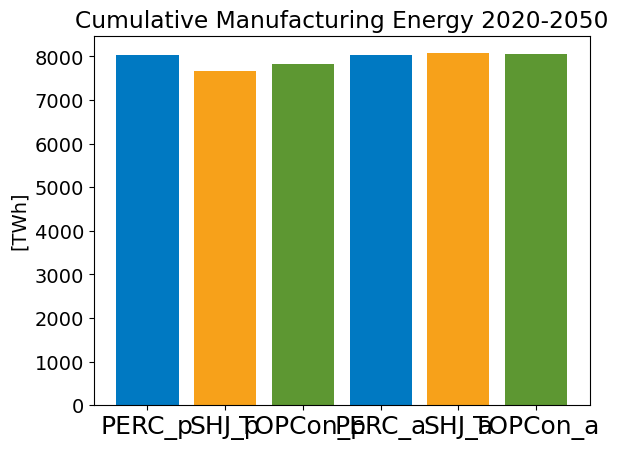

In [98]:
plt.bar(energy_demand_total_cum_2050.columns, energy_demand_total_cum_2050.loc[2050]/1e12, tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Cumulative Manufacturing Energy 2020-2050')
plt.ylabel('[TWh]')

In [99]:
energyGen_cum_2050/1e12

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,292215.264217,297677.231772,294946.247994,292215.264217,313039.84857,303629.601861


## Net Energy

In [100]:
net_energy_cum_2050 = (energyGen_cum_2050-energy_demand_total_cum_2050)/1e12
net_energy_cum_2050

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2050,284179.169395,290003.390235,287113.313691,284179.169395,304968.711531,295564.185442


Text(0, 0.5, '[TWh]')

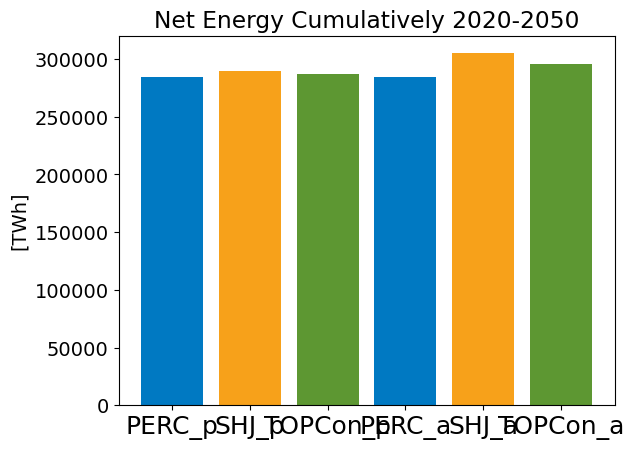

In [101]:
plt.bar(net_energy_cum_2050.columns, net_energy_cum_2050.loc[2050], tick_label=(scennames), color=['#0079C2','#F7A11A','#5D9732'])
plt.title('Net Energy Cumulatively 2020-2050')
plt.ylabel('[TWh]')

In [102]:
energyGen.columns = energy_demands_annual.columns = scennames
netEnergyAnnual_TWh = (energyGen - energy_demands_annual)/1e12

In [103]:
round(netEnergyAnnual_TWh,0)

,PERC_p,SHJ_p,TOPCon_p,PERC_a,SHJ_a,TOPCon_a
2020,192.0,203.0,198.0,192.0,213.0,203.0
2021,549.0,568.0,559.0,549.0,597.0,574.0
2022,911.0,936.0,923.0,911.0,983.0,949.0
2023,1277.0,1309.0,1293.0,1277.0,1375.0,1329.0
2024,1651.0,1690.0,1671.0,1651.0,1775.0,1717.0
2025,2028.0,2074.0,2051.0,2028.0,2179.0,2108.0
2026,2406.0,2459.0,2433.0,2406.0,2584.0,2501.0
2027,2804.0,2865.0,2835.0,2804.0,3010.0,2915.0
2028,3211.0,3279.0,3245.0,3211.0,3446.0,3337.0
2029,3652.0,3730.0,3691.0,3652.0,3920.0,3796.0


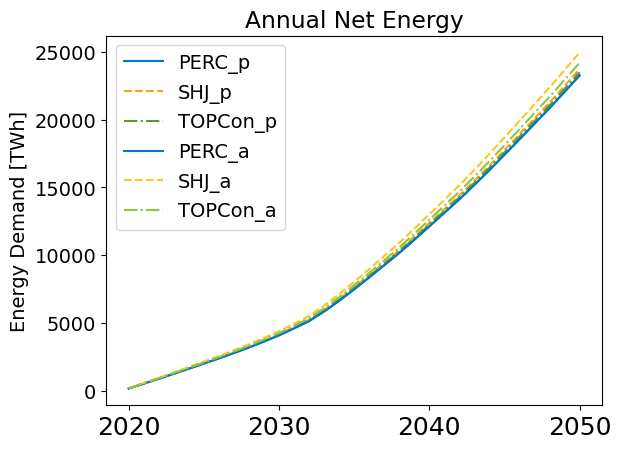

In [104]:
fig, ax1 = plt.subplots()
#ax1.plot(netEnergyAnnual_TWh)


ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[0]], color='#0079C2')
ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[1]], color='#F7A11A', ls='--')
ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[2]], color='#5D9732', ls='-.')


ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[3]], color='#0079C2')
ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[4]], color='#FFC423', ls='--')
ax1.plot(netEnergyAnnual_TWh.index, netEnergyAnnual_TWh.iloc[:,[5]], color='#8CC63F', ls='-.')
ax1.legend(scennames)

ax1.set_ylabel('Net Energy [TWh]')
plt.title('Annual Net Energy')
plt.show()

# Simulation for EROI and EBPT
Currently we dont have the ability to do cohort energy tracking. Therefore, we will test discrete points in time to evaluate a single cohort (i.e. install in only 1 year and track the energy in and out over time from that one cohort)

In [105]:
single_deploy_2020 = pd.DataFrame(index=idx_temp, columns=['MW'], dtype=float)
single_deploy_2020['MW'] = 0.0
single_deploy_2020.loc[2020,'MW'] = 100.0

In [106]:
#creating scenarios for identical power and identical area deployed
scennames2 = ['PERC','SHJ','TOPCon'] #add later Blend and bifi on/off
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [107]:
#load in a baseline and materials for modification
import PV_ICE

sim2 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames2:
    sim2.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim2.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [108]:
#trim to 2020-2050, this trims module and materials
sim2.trim_Years(startYear=2020)

#no circularity
sim2.scenMod_noCircularity()

#module eff
for scen in scennames2:
    sim2.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

#glass modify
for scen in scennames2:
    sim2.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2
    
#silver modify
for scen in scennames2:
    sim2.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values
    


endYear not provided. Setting to end year of Module data 2050


In [109]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames2:
    sim2.scenario[scen].dataIn_m.loc[0:len(single_deploy_2020.index-1),'new_Installed_Capacity_[MW]'] = single_deploy_2020.values

In [110]:
sim2.scenario['PERC'].dataIn_m

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,100.0,22.80,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,0.0,22.97,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,0.0,23.14,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,0.0,23.31,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,0.0,23.48,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
5,2025,0.0,23.65,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
6,2026,0.0,23.82,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
7,2027,0.0,23.99,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
8,2028,0.0,24.16,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
9,2029,0.0,24.33,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [111]:
for scen in scennames2:
    sim2.scenario[scen].dataIn_m.to_csv(os.path.join(testfolder,str('sim2_baseline_'+scen+'.csv')))

## 2020 Module

In [112]:
#option 1, install identical power

sim2.calculateFlows(scenarios='PERC', bifacialityfactors=bifi_perc_path)
sim2.calculateFlows(scenarios='SHJ', bifacialityfactors=bifi_shj_path)
sim2.calculateFlows(scenarios='TOPCon', bifacialityfactors=bifi_topcon_path)

#perc_p_yearly, perc_p_cum = sim2.aggregateResults(scenarios='PERC')
#shj_p_yearly, shj_p_cum = sim2.aggregateResults(scenarios='SHJ')
#topcon_p_yearly, topcon_p_cum = sim2.aggregateResults(scenarios='TOPCon')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  TOPCon
********************
Finished

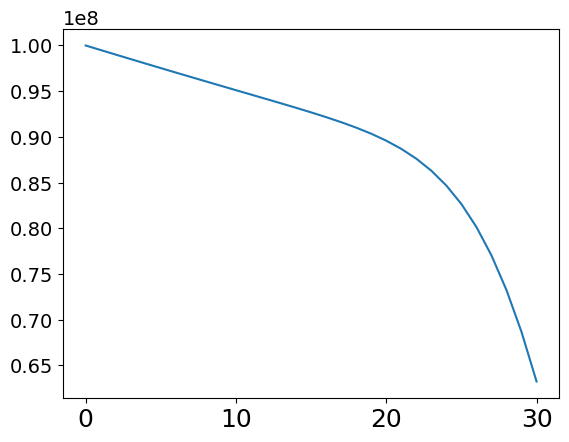

In [113]:
plt.plot(sim2.scenario['PERC'].dataOut_m['Installed_Capacity_[W]'])

In [114]:
#compile all energy out results
energy_mod2=pd.DataFrame()
for scen in scennames2:
    # add the scen name as a prefix for later filtering
    scende = sim2.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod2 = pd.concat([energy_mod2, scende], axis=1)

#energy_mod2.head()

In [115]:
energy_mat2 = pd.DataFrame()
for scen in scennames2:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim2.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat2 = pd.concat([energy_mat2, scenmatde], axis=1)

#energy_mat2.tail()

In [116]:
allenergy2 = pd.concat([energy_mod2,energy_mat2], axis=1)
allenergy2.index=idx_temp

In [117]:
allenergy2

,PERC_mod_MFG,PERC_mod_Install,PERC_mod_OandM,PERC_mod_Repair,PERC_mod_Demount,PERC_mod_Store,PERC_mod_Resell_Certify,PERC_mod_ReMFG_Disassembly,PERC_mod_Recycle_Crush,PERC_e_out_annual_[Wh],...,TOPCon_silver_mat_Recycled_LQ,TOPCon_silver_mat_Recycled_HQ,TOPCon_silicon_mat_extraction,TOPCon_silicon_mat_MFG_virgin,TOPCon_silicon_mat_MFGScrap_LQ,TOPCon_silicon_mat_MFGScrap_HQ,TOPCon_silicon_mat_Landfill,TOPCon_silicon_mat_EoL_ReMFG_clean,TOPCon_silicon_mat_Recycled_LQ,TOPCon_silicon_mat_Recycled_HQ
2020,1.406219e+09,3.894081e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.593444e+11,...,0.0,0.0,4.989132e+06,4.081271e+10,0.0,0.0,7.519185e+06,0.0,0.0,0.0
2021,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.585477e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.178295e-06,0.0,0.0,0.0
2022,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.577549e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,4.282085e-04,0.0,0.0,0.0
2023,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.569662e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.310206e-02,0.0,0.0,0.0
2024,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561813e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.429790e-01,0.0,0.0,0.0
2025,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.554004e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,8.887497e-01,0.0,0.0,0.0
2026,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.546234e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.886909e+00,0.0,0.0,0.0
2027,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.538501e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.337997e+01,0.0,0.0,0.0
2028,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.530804e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.873530e+01,0.0,0.0,0.0
2029,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.523140e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,9.838098e+01,0.0,0.0,0.0


In [118]:
perc_e_flows = allenergy2.filter(like='PERC')
perc_e_out = perc_e_flows.filter(like='e_out_annual_[Wh]')
perc_e_demand = perc_e_flows.loc[:,~perc_e_flows.columns.isin(perc_e_out.columns)] 

shj_e_flows = allenergy2.filter(like='SHJ')
shj_e_out = shj_e_flows.filter(like='e_out_annual_[Wh]')
shj_e_demand = shj_e_flows.loc[:,~shj_e_flows.columns.isin(shj_e_out.columns)] 

topcon_e_flows = allenergy2.filter(like='TOPCon')
topcon_e_out = topcon_e_flows.filter(like='e_out_annual_[Wh]')
topcon_e_demand = topcon_e_flows.loc[:,~topcon_e_flows.columns.isin(topcon_e_out.columns)] 

In [119]:
perc_e_demand_total_annual = pd.DataFrame(perc_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
shj_e_demand_total_annual = pd.DataFrame(shj_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
topcon_e_demand_total_annual = pd.DataFrame(topcon_e_demand.sum(axis=1), columns=['Wh']) #includes module and material


In [120]:
perc_e_out.columns=perc_e_demand_total_annual.columns
perc_net_energy_annual = perc_e_out-perc_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

shj_e_out.columns = shj_e_demand_total_annual.columns
shj_net_energy_annual = shj_e_out - shj_e_demand_total_annual
#shj_net_energy_annual/1e9 # GWh

topcon_e_out.columns=topcon_e_demand_total_annual.columns
topcon_net_energy_annual = topcon_e_out - topcon_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

Text(0, 0.5, 'Net Energy [GWh]')

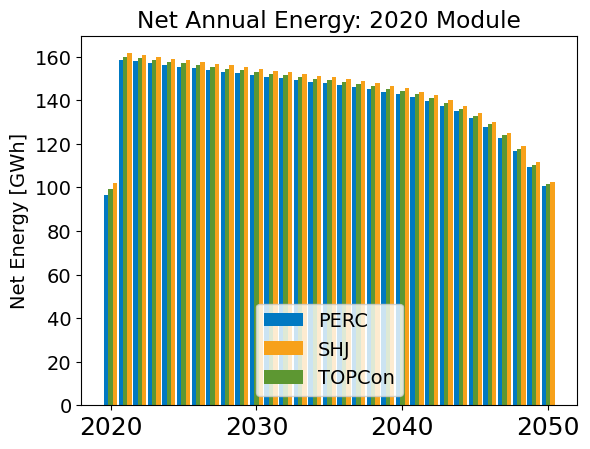

In [121]:
width = 0.3
plt.bar(perc_net_energy_annual.index-width, perc_net_energy_annual['Wh']/1e9, width, color='#0079C2')
plt.bar(shj_net_energy_annual.index+width, shj_net_energy_annual['Wh']/1e9, width, color='#F7A11A' )
plt.bar(topcon_net_energy_annual.index, topcon_net_energy_annual['Wh']/1e9, width, color='#5D9732')

plt.legend(scennames2, loc='lower center')
plt.title('Net Annual Energy: 2020 Module')
plt.ylabel('Net Energy [GWh]')

In [122]:
#EROI = Eout/Ein
perc_e_out_cum = perc_e_out.sum()
perc_e_in_cum = perc_e_demand_total_annual.sum()
EROI_perc_2020 = perc_e_out_cum[0]/perc_e_in_cum[0]
EROI_perc_2020

70.48059248401727

In [123]:
shj_e_out_cum = shj_e_out.sum()
shj_e_in_cum = shj_e_demand_total_annual.sum()
EROI_shj_2020 = shj_e_out_cum[0]/shj_e_in_cum[0]
EROI_shj_2020

74.67238683840192

In [124]:
topcon_e_out_cum = topcon_e_out.sum()
topcon_e_in_cum = topcon_e_demand_total_annual.sum()
EROI_topcon_2020 = topcon_e_out_cum[0]/topcon_e_in_cum[0]
EROI_topcon_2020

72.6826553169137

In [125]:
eroi_2020_module = pd.DataFrame({'2020 Design':[EROI_perc_2020,EROI_shj_2020,EROI_topcon_2020]}, index=['PERC','SHJ','TOPCon'])
eroi_2020_module

,2020 Design
PERC,70.480592
SHJ,74.672387
TOPCon,72.682655


## 2030 Module
Grab the module properties from 2030, and deploy 100 MW for 30 yr project life

In [126]:
idx_30_60 = pd.Series(range(2030,2061))
single_deploy_2030 = pd.DataFrame(index=idx_30_60, columns=['MW'], dtype=float)
single_deploy_2030['MW'] = 0.0
single_deploy_2030.loc[2030,'MW'] = 100.0
#single_deploy_2030

In [127]:
#creating scenarios for identical power and identical area deployed
scennames3 = ['PERC','SHJ','TOPCon'] #add later Blend and bifi on/off
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [128]:
#load in a baseline and materials for modification
import PV_ICE

sim3 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames3:
    sim3.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim3.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [129]:
#trim to 2020-2050, this trims module and materials
sim3.trim_Years(startYear=2020)

#no circularity
sim3.scenMod_noCircularity()

#module eff
for scen in scennames3:
    sim3.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

#glass modify
for scen in scennames3:
    sim3.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2
    
#silver modify
for scen in scennames3:
    sim3.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values
    


endYear not provided. Setting to end year of Module data 2050


In [130]:
#Set 2020 module and material properties = 2030
for scen in scennames3:
    sim3.scenario[scen].dataIn_m.loc[0] = sim3.scenario[scen].dataIn_m.loc[10] #reassign row values from 2030 to 2020
    sim3.scenario[scen].dataIn_m.loc[0,'year'] = 2020 #fix the overwrite
    
sim3.scenario[scen].dataIn_m.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,27744.39138,25.00,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,16455.56000,23.38,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,15227.23000,23.56,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,15224.02000,23.74,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,16634.43000,23.92,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [131]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames3:
    sim3.scenario[scen].dataIn_m.loc[0:len(single_deploy_2020.index-1),'new_Installed_Capacity_[MW]'] = single_deploy_2020.values

In [132]:
sim3.scenario[scen].dataIn_m.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,100.0,25.00,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,0.0,23.38,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,0.0,23.56,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,0.0,23.74,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,0.0,23.92,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [133]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

#for scen in scennames2:
#    sim2.scenario[scen].dataIn_m.loc[0:len(single_deploy_2030.index-1),'new_Installed_Capacity_[MW]'] = single_deploy_2030.values

In [134]:
#option 1, install identical power

sim3.calculateFlows(scenarios='PERC', bifacialityfactors=bifi_perc_path)
sim3.calculateFlows(scenarios='SHJ', bifacialityfactors=bifi_shj_path)
sim3.calculateFlows(scenarios='TOPCon', bifacialityfactors=bifi_topcon_path)

#perc_p_yearly, perc_p_cum = sim2.aggregateResults(scenarios='PERC')
#shj_p_yearly, shj_p_cum = sim2.aggregateResults(scenarios='SHJ')
#topcon_p_yearly, topcon_p_cum = sim2.aggregateResults(scenarios='TOPCon')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  TOPCon
********************
Finished

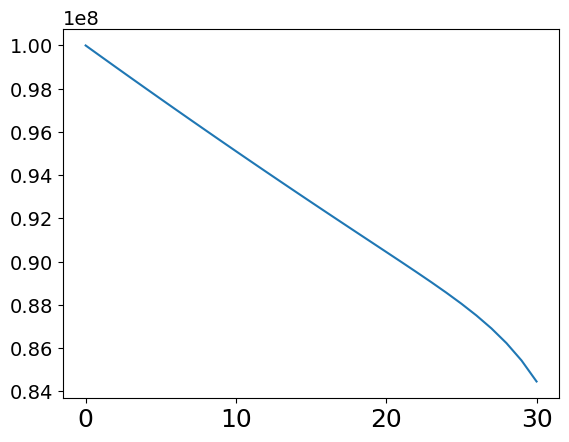

In [135]:
plt.plot(sim3.scenario['PERC'].dataOut_m['Installed_Capacity_[W]'])

In [136]:
#compile all energy out results
energy_mod3=pd.DataFrame()
for scen in scennames3:
    # add the scen name as a prefix for later filtering
    scende = sim3.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod3 = pd.concat([energy_mod3, scende], axis=1)

#energy_mod2.head()

In [137]:
#compile material energy demands
energy_mat3 = pd.DataFrame()
for scen in scennames3:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim3.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat3 = pd.concat([energy_mat3, scenmatde], axis=1)

#energy_mat3.tail()

In [138]:
allenergy3 = pd.concat([energy_mod3,energy_mat3], axis=1)
allenergy3.index=idx_30_60

In [139]:
allenergy3

,PERC_mod_MFG,PERC_mod_Install,PERC_mod_OandM,PERC_mod_Repair,PERC_mod_Demount,PERC_mod_Store,PERC_mod_Resell_Certify,PERC_mod_ReMFG_Disassembly,PERC_mod_Recycle_Crush,PERC_e_out_annual_[Wh],...,TOPCon_silver_mat_Recycled_LQ,TOPCon_silver_mat_Recycled_HQ,TOPCon_silicon_mat_extraction,TOPCon_silicon_mat_MFG_virgin,TOPCon_silicon_mat_MFGScrap_LQ,TOPCon_silicon_mat_MFGScrap_HQ,TOPCon_silicon_mat_Landfill,TOPCon_silicon_mat_EoL_ReMFG_clean,TOPCon_silicon_mat_Recycled_LQ,TOPCon_silicon_mat_Recycled_HQ
2030,1.308645e+09,3.623879e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.593444e+11,...,0.0,0.0,4.629915e+06,3.787420e+10,0.0,0.0,6.977804e+06,0.0,0.0,0.0
2031,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.585477e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2032,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.577549e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2033,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.569662e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,6.147955e-08,0.0,0.0,0.0
2034,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561813e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,2.254250e-06,0.0,0.0,0.0
2035,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.554004e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.617925e-05,0.0,0.0,0.0
2036,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.546234e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.441391e-04,0.0,0.0,0.0
2037,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.538503e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,2.284582e-03,0.0,0.0,0.0
2038,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.530811e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.167235e-02,0.0,0.0,0.0
2039,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.523157e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,4.888167e-02,0.0,0.0,0.0


In [140]:
perc_e_flows = allenergy3.filter(like='PERC')
perc_e_out = perc_e_flows.filter(like='e_out_annual_[Wh]')
perc_e_demand = perc_e_flows.loc[:,~perc_e_flows.columns.isin(perc_e_out.columns)] 

shj_e_flows = allenergy3.filter(like='SHJ')
shj_e_out = shj_e_flows.filter(like='e_out_annual_[Wh]')
shj_e_demand = shj_e_flows.loc[:,~shj_e_flows.columns.isin(shj_e_out.columns)] 

topcon_e_flows = allenergy3.filter(like='TOPCon')
topcon_e_out = topcon_e_flows.filter(like='e_out_annual_[Wh]')
topcon_e_demand = topcon_e_flows.loc[:,~topcon_e_flows.columns.isin(topcon_e_out.columns)] 

In [141]:
perc_e_demand_total_annual = pd.DataFrame(perc_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
shj_e_demand_total_annual = pd.DataFrame(shj_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
topcon_e_demand_total_annual = pd.DataFrame(topcon_e_demand.sum(axis=1), columns=['Wh']) #includes module and material


In [142]:
perc_e_out.columns=perc_e_demand_total_annual.columns
perc_net_energy_annual = perc_e_out-perc_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

shj_e_out.columns = shj_e_demand_total_annual.columns
shj_net_energy_annual = shj_e_out - shj_e_demand_total_annual
#shj_net_energy_annual/1e9 # GWh

topcon_e_out.columns=topcon_e_demand_total_annual.columns
topcon_net_energy_annual = topcon_e_out - topcon_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

Text(0, 0.5, 'Net Energy [GWh]')

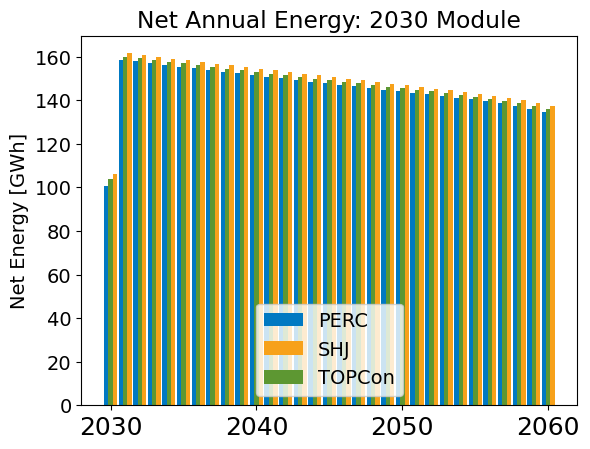

In [143]:
width = 0.3
plt.bar(perc_net_energy_annual.index-width, perc_net_energy_annual['Wh']/1e9, width, color='#0079C2')
plt.bar(shj_net_energy_annual.index+width, shj_net_energy_annual['Wh']/1e9, width, color='#F7A11A' )
plt.bar(topcon_net_energy_annual.index, topcon_net_energy_annual['Wh']/1e9, width, color='#5D9732')

plt.legend(scennames2, loc='lower center')
plt.title('Net Annual Energy: 2030 Module')
plt.ylabel('Net Energy [GWh]')

In [144]:
#EROI = Eout/Ein
perc_e_out_cum = perc_e_out.sum()
perc_e_in_cum = perc_e_demand_total_annual.sum()
EROI_perc_2030 = perc_e_out_cum[0]/perc_e_in_cum[0]
EROI_perc_2030

78.21480502638585

In [145]:
shj_e_out_cum = shj_e_out.sum()
shj_e_in_cum = shj_e_demand_total_annual.sum()
EROI_shj_2030 = shj_e_out_cum[0]/shj_e_in_cum[0]
EROI_shj_2030

83.02205578807522

In [146]:
topcon_e_out_cum = topcon_e_out.sum()
topcon_e_in_cum = topcon_e_demand_total_annual.sum()
EROI_topcon_2030 = topcon_e_out_cum[0]/topcon_e_in_cum[0]
EROI_topcon_2030

80.88479981156274

In [147]:
eroi_2030_module = pd.DataFrame({'2030 Design':[EROI_perc_2030,EROI_shj_2030,EROI_topcon_2030]}, index=['PERC','SHJ','TOPCon'])
eroi_2030_module

,2030 Design
PERC,78.214805
SHJ,83.022056
TOPCon,80.884800


## 2050 Module

In [148]:
idx_50_80 = pd.Series(range(2050,2081))


In [149]:
#creating scenarios for identical power and identical area deployed
scennames4 = ['PERC','SHJ','TOPCon'] #add later Blend and bifi on/off
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [150]:
#load in a baseline and materials for modification
import PV_ICE

sim4 = PV_ICE.Simulation(name='sim1', path=testfolder)
for scen in scennames4:
    sim4.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim4.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [151]:
#trim to 2020-2050, this trims module and materials
sim4.trim_Years(startYear=2020)

#no circularity
sim4.scenMod_noCircularity()

#module eff
for scen in scennames4:
    sim4.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

#glass modify
for scen in scennames4:
    sim4.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2
    
#silver modify
for scen in scennames4:
    sim4.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values
    


endYear not provided. Setting to end year of Module data 2050


In [152]:
#Set 2020 module and material properties = 2030
for scen in scennames4:
    sim4.scenario[scen].dataIn_m.loc[0] = sim4.scenario[scen].dataIn_m.iloc[-1] #reassign row values from 2030 to 2020
    sim4.scenario[scen].dataIn_m.loc[0,'year'] = 2020 #fix the overwrite
    
sim4.scenario[scen].dataIn_m.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,152662.6502,25.00,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,16455.5600,23.38,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,15227.2300,23.56,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,15224.0200,23.74,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,16634.4300,23.92,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [153]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

for scen in scennames4:
    sim4.scenario[scen].dataIn_m.loc[0:len(single_deploy_2020.index-1),'new_Installed_Capacity_[MW]'] = single_deploy_2020.values

In [154]:
sim4.scenario[scen].dataIn_m.head()

,year,new_Installed_Capacity_[MW],mod_eff,mod_reliability_t50,mod_reliability_t90,mod_degradation,mod_lifetime,mod_MFG_eff,mod_Repair,mod_MerchantTail,...,mod_EOL_pg2_stored,mod_EOL_pg3_reMFG,mod_EOL_pg4_recycled,mod_EOL_reMFG_yield,mod_EOL_sp_reMFG_recycle,mod_EOL_pb1_landfill,mod_EOL_pb2_stored,mod_EOL_pb3_reMFG,mod_EOL_pb4_recycled,mod_EOL_collection_eff
0,2020,100.0,25.00,40.0,44.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
1,2021,0.0,23.38,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
2,2022,0.0,23.56,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
3,2023,0.0,23.74,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,2024,0.0,23.92,33.0,38.0,0.5,35.0,98.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [155]:
#deployment projection
#NEED TO PULL IN DEPLOYMENT PROJECTION

#for scen in scennames2:
#    sim2.scenario[scen].dataIn_m.loc[0:len(single_deploy_2030.index-1),'new_Installed_Capacity_[MW]'] = single_deploy_2030.values

In [156]:
#option 1, install identical power

sim4.calculateFlows(scenarios='PERC', bifacialityfactors=bifi_perc_path)
sim4.calculateFlows(scenarios='SHJ', bifacialityfactors=bifi_shj_path)
sim4.calculateFlows(scenarios='TOPCon', bifacialityfactors=bifi_topcon_path)

#perc_p_yearly, perc_p_cum = sim2.aggregateResults(scenarios='PERC')
#shj_p_yearly, shj_p_cum = sim2.aggregateResults(scenarios='SHJ')
#topcon_p_yearly, topcon_p_cum = sim2.aggregateResults(scenarios='TOPCon')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ
********************
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  TOPCon
********************
Finished

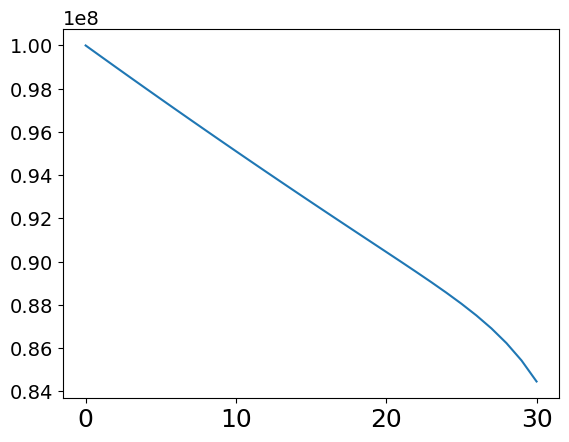

In [157]:
plt.plot(sim4.scenario['PERC'].dataOut_m['Installed_Capacity_[W]'])

In [158]:
#compile all energy out results
energy_mod4=pd.DataFrame()
for scen in scennames4:
    # add the scen name as a prefix for later filtering
    scende = sim4.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_mod4 = pd.concat([energy_mod4, scende], axis=1)

#energy_mod2.head()

In [159]:
#compile material energy demands
energy_mat4 = pd.DataFrame()
for scen in scennames4:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim4.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat4 = pd.concat([energy_mat4, scenmatde], axis=1)

#energy_mat3.tail()

In [160]:
allenergy4 = pd.concat([energy_mod4,energy_mat4], axis=1)
allenergy4.index=idx_50_80

In [161]:
allenergy4

,PERC_mod_MFG,PERC_mod_Install,PERC_mod_OandM,PERC_mod_Repair,PERC_mod_Demount,PERC_mod_Store,PERC_mod_Resell_Certify,PERC_mod_ReMFG_Disassembly,PERC_mod_Recycle_Crush,PERC_e_out_annual_[Wh],...,TOPCon_silver_mat_Recycled_LQ,TOPCon_silver_mat_Recycled_HQ,TOPCon_silicon_mat_extraction,TOPCon_silicon_mat_MFG_virgin,TOPCon_silicon_mat_MFGScrap_LQ,TOPCon_silicon_mat_MFGScrap_HQ,TOPCon_silicon_mat_Landfill,TOPCon_silicon_mat_EoL_ReMFG_clean,TOPCon_silicon_mat_Recycled_LQ,TOPCon_silicon_mat_Recycled_HQ
2050,1.308645e+09,3.623879e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.593444e+11,...,0.0,0.0,4.629915e+06,3.787420e+10,0.0,0.0,6.977804e+06,0.0,0.0,0.0
2051,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.585477e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2052,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.577549e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2053,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.569662e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,6.147955e-08,0.0,0.0,0.0
2054,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561813e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,2.254250e-06,0.0,0.0,0.0
2055,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.554004e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.617925e-05,0.0,0.0,0.0
2056,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.546234e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,3.441391e-04,0.0,0.0,0.0
2057,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.538503e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,2.284582e-03,0.0,0.0,0.0
2058,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.530811e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.167235e-02,0.0,0.0,0.0
2059,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.523157e+11,...,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,4.888167e-02,0.0,0.0,0.0


In [162]:
perc_e_flows = allenergy4.filter(like='PERC')
perc_e_out = perc_e_flows.filter(like='e_out_annual_[Wh]')
perc_e_demand = perc_e_flows.loc[:,~perc_e_flows.columns.isin(perc_e_out.columns)] 

shj_e_flows = allenergy4.filter(like='SHJ')
shj_e_out = shj_e_flows.filter(like='e_out_annual_[Wh]')
shj_e_demand = shj_e_flows.loc[:,~shj_e_flows.columns.isin(shj_e_out.columns)] 

topcon_e_flows = allenergy4.filter(like='TOPCon')
topcon_e_out = topcon_e_flows.filter(like='e_out_annual_[Wh]')
topcon_e_demand = topcon_e_flows.loc[:,~topcon_e_flows.columns.isin(topcon_e_out.columns)] 

In [163]:
perc_e_demand_total_annual = pd.DataFrame(perc_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
shj_e_demand_total_annual = pd.DataFrame(shj_e_demand.sum(axis=1), columns=['Wh']) #includes module and material
topcon_e_demand_total_annual = pd.DataFrame(topcon_e_demand.sum(axis=1), columns=['Wh']) #includes module and material


In [164]:
perc_e_out.columns=perc_e_demand_total_annual.columns
perc_net_energy_annual = perc_e_out-perc_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

shj_e_out.columns = shj_e_demand_total_annual.columns
shj_net_energy_annual = shj_e_out - shj_e_demand_total_annual
#shj_net_energy_annual/1e9 # GWh

topcon_e_out.columns=topcon_e_demand_total_annual.columns
topcon_net_energy_annual = topcon_e_out - topcon_e_demand_total_annual
#perc_net_energy_annual/1e9 # GWh

Text(0, 0.5, 'Net Energy [GWh]')

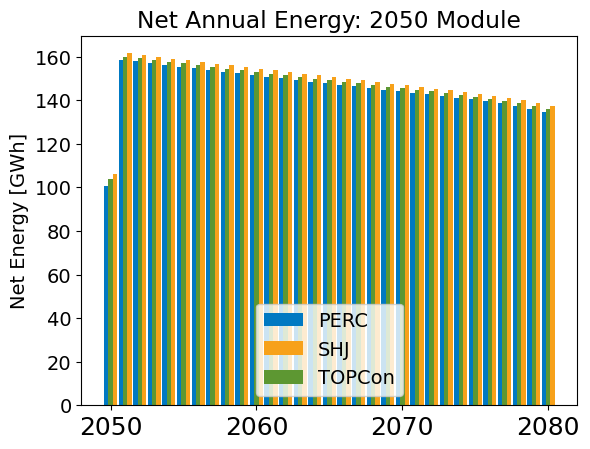

In [165]:
width = 0.3
plt.bar(perc_net_energy_annual.index-width, perc_net_energy_annual['Wh']/1e9, width, color='#0079C2')
plt.bar(shj_net_energy_annual.index+width, shj_net_energy_annual['Wh']/1e9, width, color='#F7A11A' )
plt.bar(topcon_net_energy_annual.index, topcon_net_energy_annual['Wh']/1e9, width, color='#5D9732')

plt.legend(scennames2, loc='lower center')
plt.title('Net Annual Energy: 2050 Module')
plt.ylabel('Net Energy [GWh]')

In [166]:
#EROI = Eout/Ein
perc_e_out_cum = perc_e_out.sum()
perc_e_in_cum = perc_e_demand_total_annual.sum()
EROI_perc_2050 = perc_e_out_cum[0]/perc_e_in_cum[0]
EROI_perc_2050

78.21480502638585

In [167]:
shj_e_out_cum = shj_e_out.sum()
shj_e_in_cum = shj_e_demand_total_annual.sum()
EROI_shj_2050 = shj_e_out_cum[0]/shj_e_in_cum[0]
EROI_shj_2050

83.02205578807522

In [168]:
topcon_e_out_cum = topcon_e_out.sum()
topcon_e_in_cum = topcon_e_demand_total_annual.sum()
EROI_topcon_2050 = topcon_e_out_cum[0]/topcon_e_in_cum[0]
EROI_topcon_2050

80.88479981156274

In [169]:
eroi_2050_module = pd.DataFrame({'2050 Design':[EROI_perc_2050,EROI_shj_2050,EROI_topcon_2050]}, index=['PERC','SHJ','TOPCon'])
eroi_2050_module

,2050 Design
PERC,78.214805
SHJ,83.022056
TOPCon,80.884800


Normalize the EROI to PERC 2020

In [170]:
eroi_overtime = pd.concat([eroi_2020_module,eroi_2030_module,eroi_2050_module], axis =1)
eroi_overtime

,2020 Design,2030 Design,2050 Design
PERC,70.480592,78.214805,78.214805
SHJ,74.672387,83.022056,83.022056
TOPCon,72.682655,80.884800,80.884800


In [171]:
eroi_overtime_normalized = eroi_overtime/eroi_overtime.loc['PERC','2020 Design']
eroi_overtime_normalized

,2020 Design,2030 Design,2050 Design
PERC,1.000000,1.109735,1.109735
SHJ,1.059474,1.177942,1.177942
TOPCon,1.031244,1.147618,1.147618


## Manufacturing Energy of One module each year

Assuming a 2.0 m^2 module

In [172]:
scennames_anModule = ['PERC_anModule','SHJ_anModule','TOPCon_anModule']
bifipaths = [bifi_perc_path,bifi_shj_path,bifi_topcon_path]

In [173]:
#create an area dataframe to feed in a module each year
idx_temp = Aguse.index #grab matching index
area_deploy_anModule = pd.DataFrame(index=idx_temp, dtype=float) #create an empty DF
area_deploy_anModule['Area'] = 2.0
area_deploy_anModule.head()

,Area
2020,2.0
2021,2.0
2022,2.0
2023,2.0
2024,2.0


In [174]:
#creating scenarios for identical power and identical area deployed
MATERIALS = ['glass','silver','silicon'] #, 'copper', 'encapsulant', 'backsheet', 'aluminum_frames'
moduleFile_m = os.path.join(baselinesfolder, 'baseline_modules_mass_US.csv')
moduleFile_e = os.path.join(baselinesfolder, 'baseline_modules_energy.csv')

In [175]:
#load in a baseline and materials for modification
import PV_ICE

sim_anModule = PV_ICE.Simulation(name='sim_anModule', path=testfolder)
for scen in scennames_anModule:
    sim_anModule.createScenario(name=scen, massmodulefile=moduleFile_m, energymodulefile=moduleFile_e)
    for mat in range (0, len(MATERIALS)):
        matbaseline_m = os.path.join(baselinesfolder,'baseline_material_mass_'+MATERIALS[mat]+'.csv')
        matbaseline_e = os.path.join(baselinesfolder,'baseline_material_energy_'+MATERIALS[mat]+'.csv')
        sim_anModule.scenario[scen].addMaterial(MATERIALS[mat], massmatfile=matbaseline_m, energymatfile=matbaseline_e)

path = C:\Users\hmirletz\Documents\GitHub\PV_ICE\PV_ICE\TEMP\CellTechCompare


Modify the all one tech scenarios Scenarios:

Module level
- trim to 2020-2050
- no circularity
- deployment projection
- module eff

material level
- glass per m2
- silver per m2

In [176]:
#trim to 2020-2050, this trims module and materials
sim_anModule.trim_Years(startYear=2020)

#no circularity
sim_anModule.scenMod_noCircularity()

#module eff
for scen in scennames_anModule:
    sim_anModule.scenario[scen].dataIn_m.loc[0:len(modeffs.index-1),'mod_eff'] = modeffs.filter(like=str(scen[0:3])).values

#glass modify
for scen in scennames_anModule:
    sim_anModule.scenario[scen].material['glass'].matdataIn_m['mat_massperm2'] = glassperm2
    
#silver modify
for scen in scennames_anModule:
    sim_anModule.scenario[scen].material['silver'].matdataIn_m.loc[0:len(Aguse.index-1),'mat_massperm2'] = Aguse.filter(like=str(scen[0:3])).values
    


endYear not provided. Setting to end year of Module data 2050


In [177]:
#option 1, install identical power
sim_anModule.calculateFlows(scenarios='PERC_anModule', bifacialityfactors=bifi_perc_path, installByArea=list(area_deploy_anModule['Area']))
sim_anModule.calculateFlows(scenarios='SHJ_anModule', bifacialityfactors=bifi_shj_path,  installByArea=list(area_deploy_anModule['Area']))
sim_anModule.calculateFlows(scenarios='TOPCon_anModule', bifacialityfactors=bifi_topcon_path,  installByArea=list(area_deploy_anModule['Area']))

perc_anModule_yearly, perc_anModule_cum = sim_anModule.aggregateResults(scenarios='PERC_anModule')
shj_anModule_yearly, shj_anModule_cum = sim_anModule.aggregateResults(scenarios='SHJ_anModule')
topcon_anModule_yearly, topcon_anModule_cum = sim_anModule.aggregateResults(scenarios='TOPCon_anModule')

>>>> Calculating Material Flows <<<<

Working on Scenario:  PERC_anModule
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  PERC_anModule
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  silver
==> Working on Energy for Material :  silicon
>>>> Calculating Material Flows <<<<

Working on Scenario:  SHJ_anModule
********************
Calculating installed capacity based on installed Area
Finished Area+Power Generation Calculations
==> Working on Material :  glass
==> Working on Material :  silver
==> Working on Material :  silicon


>>>> Calculating Energy Flows <<<<

Working on Scenario:  SHJ_anModule
********************
==> Working on Energy for Material :  glass
==> Working on Energy for Material :  sil

In [178]:
anModule_yearly, anModule_cum = sim_anModule.aggregateResults()
anModule_yearly.columns

Index(['VirginStock_glass_sim_anModule_PERC_anModule_[Tonnes]',
       'VirginStock_silver_sim_anModule_PERC_anModule_[Tonnes]',
       'VirginStock_silicon_sim_anModule_PERC_anModule_[Tonnes]',
       'VirginStock_Module_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteAll_glass_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteAll_silver_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteAll_silicon_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteAll_Module_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteEOL_glass_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteEOL_silver_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteEOL_silicon_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteEOL_Module_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteMFG_glass_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteMFG_silver_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteMFG_silicon_sim_anModule_PERC_anModule_[Tonnes]',
       'WasteMFG_Module_sim_anModule_PERC_anModule_[Tonnes

In [179]:
#compile all energy out results
energy_anModule=pd.DataFrame()
for scen in scennames_anModule:
    # add the scen name as a prefix for later filtering
    scende = sim_anModule.scenario[scen].dataOut_e.loc[0:30].add_prefix(str(scen+'_'))
    #concat into one large df
    energy_anModule = pd.concat([energy_anModule, scende], axis=1)

energy_anModule.tail()

,PERC_anModule_mod_MFG,PERC_anModule_mod_Install,PERC_anModule_mod_OandM,PERC_anModule_mod_Repair,PERC_anModule_mod_Demount,PERC_anModule_mod_Store,PERC_anModule_mod_Resell_Certify,PERC_anModule_mod_ReMFG_Disassembly,PERC_anModule_mod_Recycle_Crush,PERC_anModule_e_out_annual_[Wh],...,TOPCon_anModule_mod_MFG,TOPCon_anModule_mod_Install,TOPCon_anModule_mod_OandM,TOPCon_anModule_mod_Repair,TOPCon_anModule_mod_Demount,TOPCon_anModule_mod_Store,TOPCon_anModule_mod_Resell_Certify,TOPCon_anModule_mod_ReMFG_Disassembly,TOPCon_anModule_mod_Recycle_Crush,TOPCon_anModule_e_out_annual_[Wh]
26,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.067538e+07,...,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.148285e+07
27,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.133202e+07,...,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.216570e+07
28,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.196186e+07,...,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.282074e+07
29,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.256010e+07,...,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.344300e+07
30,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.312194e+07,...,6775.510204,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.402748e+07


In [180]:
energy_mat_anModule = pd.DataFrame()
for scen in scennames_anModule:
    for mat in MATERIALS:
        # add the scen name as a prefix for later filtering
        scenmatde = sim_anModule.scenario[scen].material[mat].matdataOut_e.loc[0:30].add_prefix(str(scen+'_'+mat+'_'))
        #concat into one large df
        energy_mat_anModule = pd.concat([energy_mat_anModule, scenmatde], axis=1)

energy_mat_anModule.tail()

,PERC_anModule_glass_mat_extraction,PERC_anModule_glass_mat_MFG_virgin,PERC_anModule_glass_mat_MFGScrap_LQ,PERC_anModule_glass_mat_MFGScrap_HQ,PERC_anModule_glass_mat_Landfill,PERC_anModule_glass_mat_EoL_ReMFG_clean,PERC_anModule_glass_mat_Recycled_LQ,PERC_anModule_glass_mat_Recycled_HQ,PERC_anModule_silver_mat_extraction,PERC_anModule_silver_mat_MFG_virgin,...,TOPCon_anModule_silver_mat_Recycled_LQ,TOPCon_anModule_silver_mat_Recycled_HQ,TOPCon_anModule_silicon_mat_extraction,TOPCon_anModule_silicon_mat_MFG_virgin,TOPCon_anModule_silicon_mat_MFGScrap_LQ,TOPCon_anModule_silicon_mat_MFGScrap_HQ,TOPCon_anModule_silicon_mat_Landfill,TOPCon_anModule_silicon_mat_EoL_ReMFG_clean,TOPCon_anModule_silicon_mat_Recycled_LQ,TOPCon_anModule_silicon_mat_Recycled_HQ
26,266.268123,90515.451144,0.0,0.0,251.074944,0.0,0.0,0.0,0.107141,1044.626008,...,0.0,0.0,19.618483,160760.811002,0.0,0.0,31.063486,0.0,0.0,0.0
27,266.268123,90515.451144,0.0,0.0,313.168799,0.0,0.0,0.0,0.105043,1024.166743,...,0.0,0.0,19.618483,160760.811002,0.0,0.0,32.958173,0.0,0.0,0.0
28,266.268123,90515.451144,0.0,0.0,390.614833,0.0,0.0,0.0,0.102944,1003.707478,...,0.0,0.0,19.618483,160760.811002,0.0,0.0,35.317540,0.0,0.0,0.0
29,266.268123,90515.451144,0.0,0.0,484.779234,0.0,0.0,0.0,0.100846,983.248213,...,0.0,0.0,19.618483,160760.811002,0.0,0.0,38.180861,0.0,0.0,0.0
30,266.268123,90515.451144,0.0,0.0,595.957201,0.0,0.0,0.0,0.098748,962.788948,...,0.0,0.0,19.618483,160760.811002,0.0,0.0,41.553836,0.0,0.0,0.0


In [181]:
allenergy_anModule = pd.concat([energy_anModule,energy_mat_anModule], axis=1)
allenergy_anModule.index=idx_temp

In [182]:
remove = allenergy_anModule.filter(like='e_out_annual').columns
energy_demand_anModule = allenergy_anModule.drop(columns=remove)

In [183]:
energy_demand_anModule_perc = energy_demand_anModule.filter(like='PERC')
energy_demand_anModule_shj = energy_demand_anModule.filter(like='SHJ')
energy_demand_anModule_topcon = energy_demand_anModule.filter(like='TOPCon')


In [184]:
energy_demand_anModule_perc_cum = pd.DataFrame(energy_demand_anModule_perc.sum(axis=1), columns=['E_mfg_anModule_[Wh]'])
energy_demand_anModule_shj_cum = pd.DataFrame(energy_demand_anModule_shj.sum(axis=1), columns=['E_mfg_anModule_[Wh]'])
energy_demand_anModule_topcon_cum = pd.DataFrame(energy_demand_anModule_topcon.sum(axis=1), columns=['E_mfg_anModule_[Wh]'])
mfg_anModule = pd.concat([energy_demand_anModule_perc_cum,energy_demand_anModule_shj_cum,energy_demand_anModule_topcon_cum], axis=1)
mfg_anModule.columns = scennames_anModule

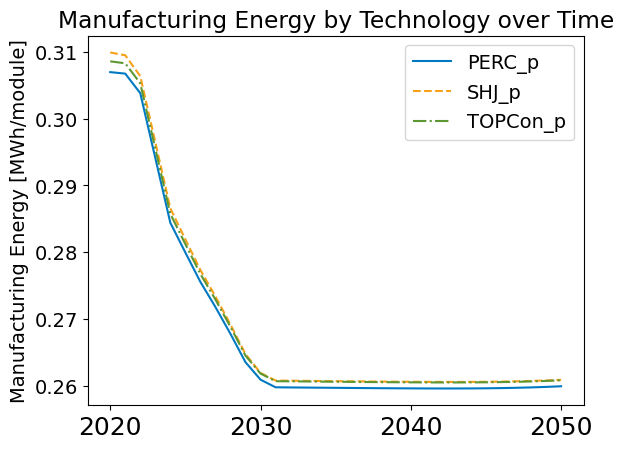

In [185]:
fig, ax1 = plt.subplots()
#ax1.plot(netEnergyAnnual_TWh)


ax1.plot(energy_demand_anModule_perc_cum/1e6, color='#0079C2')
ax1.plot(energy_demand_anModule_shj_cum/1e6, color='#F7A11A', ls='--')
ax1.plot(energy_demand_anModule_topcon_cum/1e6, color='#5D9732', ls='-.')

plt.legend(scennames)
#ax1.set_yscale('log')
ax1.set_ylabel('Manufacturing Energy [MWh/module]')
plt.title('Manufacturing Energy by Technology over Time')
plt.rc('font', size=18) #controls default text size
plt.show()

In [186]:
#mfg_anModule
#shows that they are in fact slightly different energy demands between technologies.
#lets divide by PERC and see % wise how different.
mfg_anModule_normalized = mfg_anModule.iloc[:,[0,1,2]]/mfg_anModule.iloc[:,[0]].values
mfg_anModule_normalized#.loc[[2050]]

,PERC_anModule,SHJ_anModule,TOPCon_anModule
2020,1.0,1.009569,1.005255
2021,1.0,1.008948,1.005031
2022,1.0,1.008400,1.004850
2023,1.0,1.008022,1.004772
2024,1.0,1.007618,1.004689
2025,1.0,1.007051,1.004514
2026,1.0,1.006465,1.004333
2027,1.0,1.005846,1.004136
2028,1.0,1.005214,1.003937
2029,1.0,1.004567,1.003736


separate out by module vs material energy demand

In [187]:
energy_mat_anModule_perc_glass = energy_mat_anModule.filter(like='PERC').filter(like='glass')
energy_mat_anModule_perc_si = energy_mat_anModule.filter(like='PERC').filter(like='silicon')
energy_mat_anModule_perc_ag = energy_mat_anModule.filter(like='PERC').filter(like='silver')

energy_anModule_perc_mod_temp = energy_anModule.filter(like='PERC')
remove_1 = energy_anModule.filter(like='PERC').filter(like='e_out').columns
energy_anModule_perc_mod = energy_anModule_perc_mod_temp.drop(columns=remove_1)

In [188]:
emod = energy_anModule_perc_mod.sum(axis=1)
eglass = energy_mat_anModule_perc_glass.sum(axis=1)
esi = energy_mat_anModule_perc_si.sum(axis=1)
eag = energy_mat_anModule_perc_ag.sum(axis=1)
e_bkdwn_mod_mat = pd.concat([emod,eglass,esi,eag], axis=1, keys=['mod','glass','silicon','silver'])

In [189]:
e_bkdwn_mod_mat

,mod,glass,silicon,silver
0,6880.224490,93163.892797,204583.334706,2311.103238
1,6794.510204,92868.493748,204833.232048,2217.214669
2,6794.510204,92672.575121,202202.246470,2123.326100
3,6794.510204,92380.205795,192901.317363,2029.437531
4,6794.510204,92186.291461,183495.755192,1935.548962
5,6794.510204,91993.170352,179332.162228,1841.660393
6,6794.510204,91704.965554,175318.632314,1747.771824
7,6794.510204,91513.808029,171846.221473,1653.883255
8,6794.510204,91323.430803,168122.435051,1559.994688
9,6794.510204,91039.316560,164259.795093,1466.106123


Text(0, 0.5, 'Manufacturing Energy [MWh/module]')

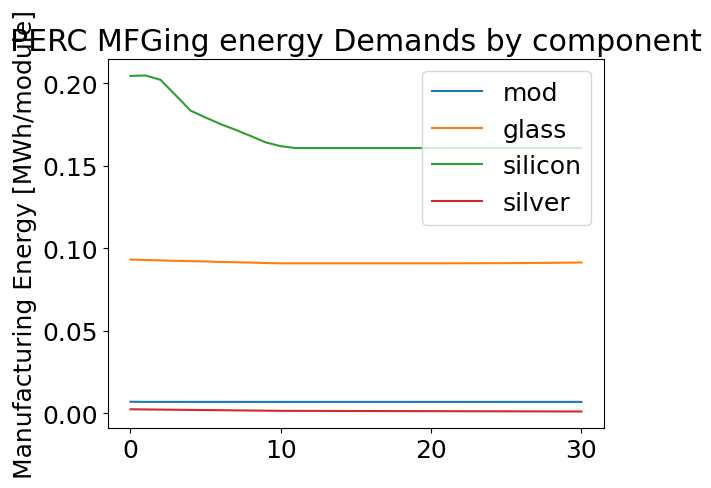

In [190]:
plt.plot(e_bkdwn_mod_mat/1e6)
plt.legend(e_bkdwn_mod_mat.columns)
plt.title('PERC MFGing energy Demands by component')
plt.ylabel('Manufacturing Energy [MWh/module]')

In [191]:
energy_mat_anModule_shj_glass = energy_mat_anModule.filter(like='SHJ').filter(like='glass')
energy_mat_anModule_shj_si = energy_mat_anModule.filter(like='SHJ').filter(like='silicon')
energy_mat_anModule_shj_ag = energy_mat_anModule.filter(like='SHJ').filter(like='silver')

energy_anModule_shj_mod_temp = energy_anModule.filter(like='SHJ')
remove_1 = energy_anModule.filter(like='SHJ').filter(like='e_out').columns
energy_anModule_shj_mod = energy_anModule_shj_mod_temp.drop(columns=remove_1)

In [192]:
emod_shj = energy_anModule_shj_mod.sum(axis=1)
eglass_shj = energy_mat_anModule_shj_glass.sum(axis=1)
esi_shj = energy_mat_anModule_shj_si.sum(axis=1)
eag_shj = energy_mat_anModule_shj_ag.sum(axis=1)
e_bkdwn_mod_mat_shj = pd.concat([emod_shj,eglass_shj,esi_shj,eag_shj], axis=1, keys=['module','glass','silicon','silver'])
idx_20_50 = pd.Series(range(2020,2051))
e_bkdwn_mod_mat_shj.index=idx_20_50

In [193]:
e_bkdwn_mod_mat_shj

,module,glass,silicon,silver
2020,6880.224490,93163.892797,204583.334706,5248.130269
2021,6794.510204,92868.493748,204833.232048,4961.649763
2022,6794.510204,92672.575121,202202.246470,4675.169258
2023,6794.510204,92380.205795,192901.317363,4388.688752
2024,6794.510204,92186.291461,183495.755192,4102.208247
2025,6794.510204,91993.170352,179332.162228,3815.727741
2026,6794.510204,91704.965554,175318.632314,3529.247236
2027,6794.510204,91513.808029,171846.221473,3242.766732
2028,6794.510204,91323.430803,168122.435051,2956.286230
2029,6794.510204,91039.316560,164259.795093,2669.805734


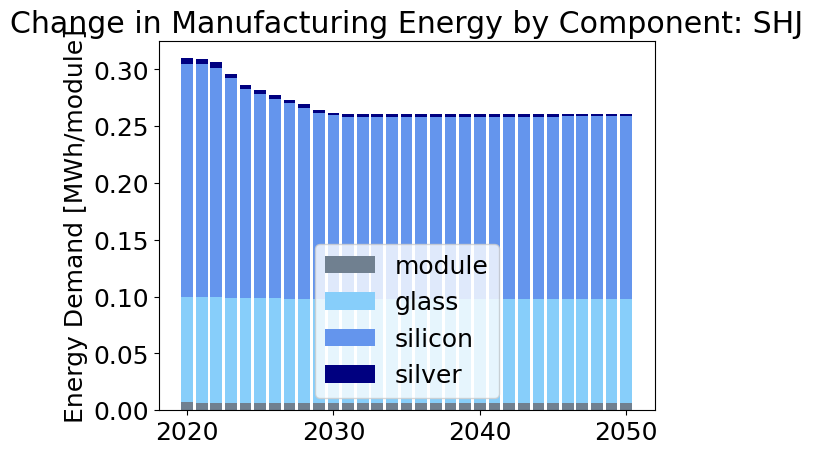

In [194]:
fig, ax = plt.subplots()

ax.bar(e_bkdwn_mod_mat_shj.index, e_bkdwn_mod_mat_shj['module']/1e6, label='module', color='slategray')
ax.bar(e_bkdwn_mod_mat_shj.index, e_bkdwn_mod_mat_shj['glass']/1e6, label='glass', color = 'lightskyblue',
       bottom=e_bkdwn_mod_mat_shj['module']/1e6)
ax.bar(e_bkdwn_mod_mat_shj.index, e_bkdwn_mod_mat_shj['silicon']/1e6, label='silicon', color='cornflowerblue',
       bottom=(e_bkdwn_mod_mat_shj['module']+e_bkdwn_mod_mat_shj['glass'])/1e6)
ax.bar(e_bkdwn_mod_mat_shj.index, e_bkdwn_mod_mat_shj['silver']/1e6, label='silver', color = 'navy',
       bottom=(e_bkdwn_mod_mat_shj['module']+e_bkdwn_mod_mat_shj['glass']+e_bkdwn_mod_mat_shj['silicon'])/1e6)

plt.legend(loc='lower center')
ax.set_ylabel('Energy Demand [MWh/module]')
plt.title('Change in Manufacturing Energy by Component: SHJ')
plt.rc('font', size=14) #controls default text size
plt.show()

In [195]:
# create an agg Energy Results based on agg mass results
    def aggregateResults_e(self, scenarios=None, materials=None):

        if scenarios is None:
            scenarios = list(self.scenario.keys())
        else:
            if isinstance(scenarios, str):
                scenarios = [scenarios]

        if materials is None:
            materials = list(self.scenario[scenarios[0]].material.keys())
        else:
            if isinstance(materials, str):
                materials = [materials]

        keywds = ['mat_Virgin_Stock', 'mat_Total_Landfilled', 'mat_Total_EOL_Landfilled', 'mat_Total_MFG_Landfilled']
        nice_keywds = ['VirginStock', 'WasteAll', 'WasteEOL', 'WasteMFG']

        USyearly=pd.DataFrame()

        for scen in scenarios:
            for ii in range(len(keywds)):
                keywd = keywds[ii]
                nicekey = nice_keywds[ii]

                for mat in materials:
                    USyearly[nicekey+'_'+mat+'_'+self.name+'_'+scen] = self.scenario[scen].material[mat].matdataOut_m[keywd]
                filter_col = [col for col in USyearly if (col.startswith(nicekey) and col.endswith(self.name+'_'+scen)) ]
                USyearly[nicekey+'_Module_'+self.name+'_'+scen] = USyearly[filter_col].sum(axis=1)
                # 2DO: Add multiple objects option


        USyearly = USyearly/1000000  # This is the ratio for grams to Metric tonnes
        USyearly = USyearly.add_suffix('_[Tonnes]')

        # Different units, so no need to do the ratio to Metric tonnes :p
        keywd1='new_Installed_Capacity_[MW]'

        for scen in scenarios:
            USyearly['newInstalledCapacity_'+self.name+'_'+scen+'_[MW]'] = self.scenario[scen].dataIn_m[keywd1]

        # Creating c umulative results
        UScum = USyearly.copy()
        UScum = UScum.cumsum()

        # Adding Installed Capacity to US (This is already 'Cumulative') so not including it in UScum
        # We are also renaming it to 'ActiveCapacity' and calculating Decommisioned Capacity.
        # TODO: Rename Installed_CApacity to ActiveCapacity throughout.
        keywd='Installed_Capacity_[W]'
        for scen in scenarios:
            USyearly['ActiveCapacity_'+self.name+'_'+scen+'_[MW]'] = self.scenario[scen].dataOut_m[keywd]/1e6
            USyearly['DecommisionedCapacity_'+self.name+'_'+scen+'_[MW]'] = (
                UScum['newInstalledCapacity_'+self.name+'_'+scen+'_[MW]']-
                USyearly['ActiveCapacity_'+self.name+'_'+scen+'_[MW]'])

        # Adding Decommissioned Capacity

        # Reindexing and Merging
        USyearly.index = self.scenario[scen].dataIn_m['year']
        UScum.index = self.scenario[scen].dataIn_m['year']

        self.USyearly = USyearly
        self.UScum = UScum

        return USyearly, UScum

IndentationError: unexpected indent (2650687228.py, line 2)